In [154]:
#!pip install mlfow

In [155]:
# Validate the data
#from mlflow.artifacts import download_artifacts
import pandas as pd

def pd_read_parquet_from_mlflow(
    #run_id: str, 
    artifact_path: str) -> pd.DataFrame:
    """Load a parquet file from an mlflow artifact.

    Args:
        run_id: the mlflow Run ID
        artifact_path: the relative (to the run) path to the parquet file
    
    Returns:
        pd.DataFrame of the loaded artifact
    """
    #local_path = download_artifacts(run_id=run_id, artifact_path=artifact_path)
    return pd.read_parquet(artifact_path)

#run_id = 'c65b6c792ff240d9a2a415dbca52e4e2'
path = 'data.parquet'
df = pd_read_parquet_from_mlflow(path)
df.head()

,user_id,ts,active_time_m7,active_time_m14,active_time_s7,active_time_s14,activity_percent_m7,activity_percent_m14,activity_percent_s7,activity_percent_s14,...,phq_q4,phq_q5,phq_q6,phq_q7,phq_q8,phq_q9,phq2_total,phq8_total,phq9_total,deployment
0,us-east-1:c0eb2431-6acb-46f5-83e4-45e2e7af7de6,2019-04-26 18:24:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hr-rct-cue-1
1,us-east-1:f2ca03e5-1614-41d4-9e8f-6d8b101d58ca,2019-02-23 03:26:16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hr-rct-cue-1
2,us-east-1:1048e352-04fe-40e3-a295-1c78c9cdf469,2019-07-06 06:29:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hr-rct-cue-1
3,us-east-1:35cb7bab-798f-47bd-9384-c63d72f75a72,2019-01-14 21:37:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hr-rct-cue-1
4,us-east-1:8176a508-e992-4b93-a5f9-18f598feea44,2019-04-18 17:11:26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,NaN,hr-rct-cue-1


In [156]:
df.shape

(12020, 158)

In [157]:
name = 'age'

colums = [col for col in df.columns if col.startswith(name)]
df[colums]

,age_bucket,age_num
0,25-34,<NA>
1,18-24,<NA>
2,<NA>,<NA>
3,55-64,<NA>
4,<NA>,<NA>
...,...,...
629,25-34,29
630,25-34,33
631,65-74,71
632,35-44,36


In [ ]:
keywords = ["major", "depressive", "disorder"]

# Get the columns whose names contain any of the keywords
filtered_columns = [col for col in df.columns if any(keyword in col for keyword in keywords)]

# Create a new DataFrame with only those columns
df[filtered_columns]

In [158]:
df.deployment.value_counts()

deployment
hr-ascent-1      10520
hr-uchealth-1      634
hr-internal-1      552
hr-rct-ctrl-1      160
hr-rct-cue-1       154
Name: count, dtype: int64

In [159]:
df.deployment.value_counts().sum()

12020

In [160]:
df[df['phq_q1'].notnull()].groupby('deployment').size().reset_index(name='count')

,deployment,count
0,hr-ascent-1,255
1,hr-internal-1,94
2,hr-rct-ctrl-1,8
3,hr-rct-cue-1,13
4,hr-uchealth-1,13


In [161]:
df = df[df.deployment == 'hr-ascent-1']
df.shape

(10520, 158)

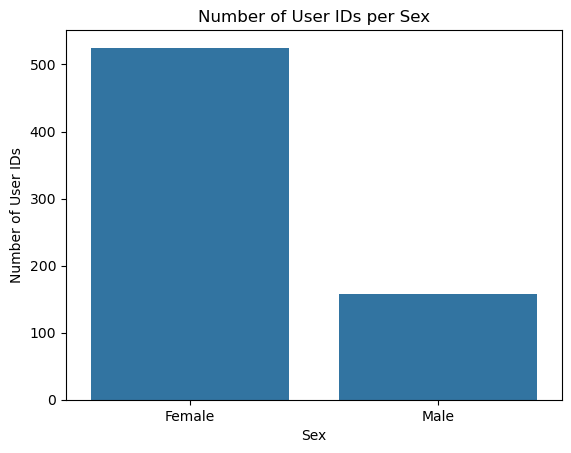

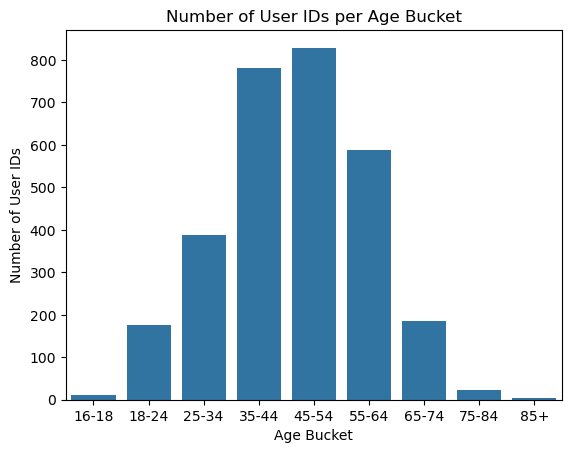

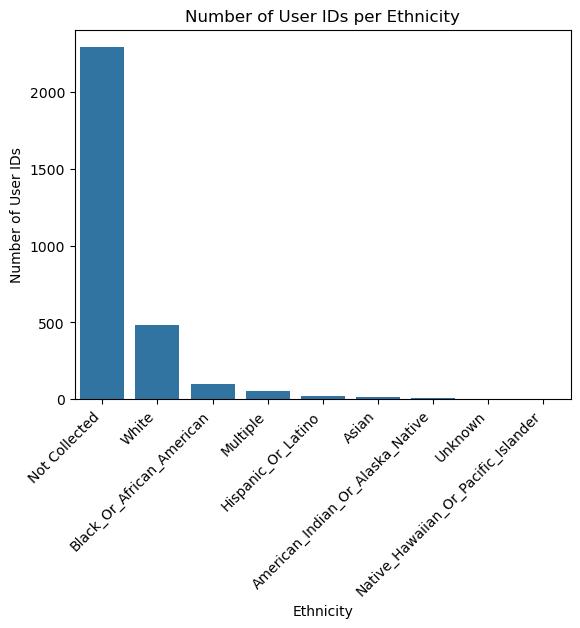

In [162]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Plot number of user_ids per sex
df_sex = df.groupby('sex').user_id.nunique().reset_index().sort_values(by='sex')
sns.barplot(data=df_sex, x='sex', y='user_id')
plt.title('Number of User IDs per Sex')
plt.xlabel('Sex')
plt.ylabel('Number of User IDs')
plt.show()

# Plot number of user_ids per age_bucket
df_age_bucket = df.groupby('age_bucket').user_id.nunique().reset_index().sort_values(by='age_bucket')
sns.barplot(data=df_age_bucket, x='age_bucket', y='user_id')
plt.title('Number of User IDs per Age Bucket')
plt.xlabel('Age Bucket')
plt.ylabel('Number of User IDs')
plt.show()

# Plot number of user_ids per ethnicity
df['ethnicity'] = df.ethnicity.apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) and len(x) == 1 else 'Multiple' if isinstance(x, (list, np.ndarray)) and len(x) > 1 else 'Not Collected')
df_ethnicity = df.groupby('ethnicity').user_id.nunique().reset_index().rename(columns={'ethnicity': 'Ethnicity', 'user_id': 'User Count'}).sort_values(by='User Count', ascending=False).reset_index(drop=True)
sns.barplot(data=df_ethnicity, x='Ethnicity', y='User Count')
plt.title('Number of User IDs per Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Number of User IDs')
plt.xticks(rotation=45, ha='right')
plt.show()

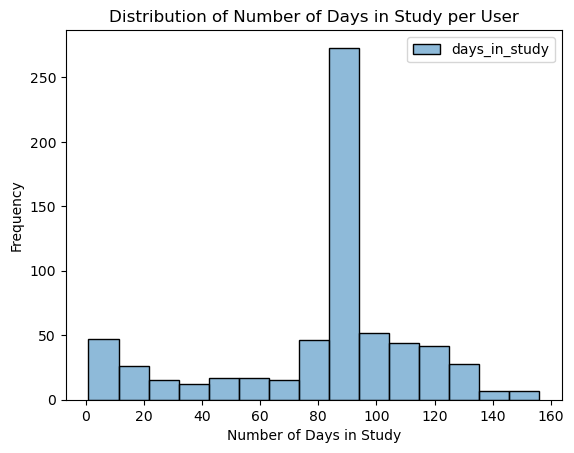

In [163]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the number of days in study for each user
df['ts'] = pd.to_datetime(df['ts'])
df_days_in_study = df.groupby('user_id').agg(
    days_in_study=('ts', lambda x: (x.max() - x.min()).days)
).reset_index()

# Plot the distribution of the number of days in study per user
sns.histplot(df_days_in_study[df_days_in_study['days_in_study']>0], bins=15)
plt.title('Distribution of Number of Days in Study per User')
plt.xlabel('Number of Days in Study')
plt.ylabel('Frequency')
plt.show()

In [164]:
df.phq_q1.notnull().mean()

0.02423954372623574

In [165]:
df.phq_q1.isna().mean()

0.9757604562737643

In [166]:
path = 'data (1).parquet'
df = pd_read_parquet_from_mlflow(path)
df.head()

,user_id,ts,active_time_m7,active_time_m14,active_time_s7,active_time_s14,activity_percent_m7,activity_percent_m14,activity_percent_s7,activity_percent_s14,...,phq_q4,phq_q5,phq_q6,phq_q7,phq_q8,phq_q9,phq2_total,phq8_total,phq9_total,deployment
0,us-east-1:1b087523-b47b-421c-97c4-74da80564598,2018-09-25 18:17:26.647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,0.0,1.0,1.0,1.0,NaN,3.0,9.0,NaN,hr-rct-cue-1
1,us-east-1:ea986d8e-e87d-458b-a798-1999fbbff05b,2018-09-26 17:13:52.394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,3.0,3.0,3.0,3.0,NaN,4.0,21.0,NaN,hr-rct-cue-1
2,us-east-1:8dfca9b6-22b6-4155-8a70-ce3e1211a684,2018-09-27 19:04:15.124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,3.0,3.0,3.0,1.0,NaN,6.0,22.0,NaN,hr-rct-cue-1
3,us-east-1:77f43bb4-fe8e-4a50-a4fc-41bc14b11f9d,2018-10-01 22:01:32.622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,1.0,2.0,2.0,0.0,NaN,2.0,10.0,NaN,hr-rct-cue-1
4,us-east-1:4940dfa3-1c01-49f2-9cdd-029291d7b7a8,2018-10-05 21:08:52.441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,3.0,3.0,1.0,0.0,NaN,6.0,18.0,NaN,hr-rct-cue-1


In [167]:
df[df['phq_q1'].notnull()].groupby('deployment').size().reset_index(name='count')

,deployment,count
0,hr-ascent-1,2924
1,hr-internal-1,1031
2,hr-rct-ctrl-1,700
3,hr-rct-cue-1,653
4,hr-uchealth-1,1512


In [168]:
df.shape

(6820, 158)

In [169]:
df.phq_q1.isna().mean()

0.0

In [170]:
df.phq_q1.notnull().mean()

1.0

In [171]:
len(df)

6820

In [172]:
len(df[['user_id', 'ts']].drop_duplicates())

6817

In [173]:
df[df.sleep_duration_m7.notnull()].sleep_duration_m7

5       26871.428571
6       25671.428571
11      19200.000000
16      26914.285714
17      26700.000000
            ...     
1497    34414.285714
1502    31242.857143
1504    28285.714286
1509    22328.571429
1511    25800.000000
Name: sleep_duration_m7, Length: 2834, dtype: float64

In [174]:
df.sleep_duration_m7.isna().mean()

0.5844574780058651

In [175]:
df.sleep_duration_m7.notnull().mean()

0.4155425219941349

In [176]:
df.groupby('deployment').sleep_duration_m7.apply(lambda x: x.notnull().mean())

# The aggregations only output a value if all days are available.
# We expect sleep_duration to be missing more often than step count, so compare.

deployment
hr-ascent-1      0.270520
hr-internal-1    0.586809
hr-rct-ctrl-1    0.672857
hr-rct-cue-1     0.609495
hr-uchealth-1    0.376323
Name: sleep_duration_m7, dtype: float64

In [177]:
df.groupby('deployment').step_count_m7.apply(lambda x: x.notnull().mean())

deployment
hr-ascent-1      0.619015
hr-internal-1    0.796314
hr-rct-ctrl-1    0.864286
hr-rct-cue-1     0.862175
hr-uchealth-1    0.803571
Name: step_count_m7, dtype: float64

In [178]:
df.groupby('deployment').sex.apply(lambda x: x.notnull().mean())

deployment
hr-ascent-1      1.000000
hr-internal-1    0.671193
hr-rct-ctrl-1    0.950000
hr-rct-cue-1     0.937213
hr-uchealth-1    0.980820
Name: sex, dtype: float64

In [179]:
df.groupby('deployment').age_bucket.apply(lambda x: x.notnull().mean())

deployment
hr-ascent-1      1.000000
hr-internal-1    0.670223
hr-rct-ctrl-1    0.950000
hr-rct-cue-1     0.937213
hr-uchealth-1    0.980820
Name: age_bucket, dtype: float64

In [180]:
df.groupby('deployment').ethnicity.apply(lambda x: x.notnull().mean())

deployment
hr-ascent-1      0.994528
hr-internal-1    0.000000
hr-rct-ctrl-1    0.000000
hr-rct-cue-1     0.000000
hr-uchealth-1    0.000000
Name: ethnicity, dtype: float64

In [279]:
df = df[df.deployment == 'hr-ascent-1']
df.shape

(2924, 161)

In [280]:
#save the df into csv file

df.to_csv('hr_ascent_1.csv', index=False)

In [281]:
df.groupby('deployment').sleep_duration_m7.apply(lambda x: x.notnull().mean())
df.groupby('deployment').step_count_m7.apply(lambda x: x.notnull().mean())
df.groupby('deployment').sex.apply(lambda x: x.notnull().mean())
df.groupby('deployment').age_bucket.apply(lambda x: x.notnull().mean())
df.groupby('deployment').ethnicity.apply(lambda x: x.notnull().mean())

deployment
hr-ascent-1    1.0
Name: ethnicity, dtype: float64

In [282]:
df['phq_q8'].describe()

count    2924.000000
mean        0.857387
std         0.991157
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: phq_q8, dtype: float64

In [283]:
df['step_count_m7'].describe()

count     1810.000000
mean      3126.063931
std       2819.509742
min         39.571429
25%       1036.642857
50%       2339.714286
75%       4358.857143
max      20911.142857
Name: step_count_m7, dtype: float64

In [284]:
percentiles = [0.80, 0.85, 0.90, 0.95, 0.98, 0.99, 0.995, 0.998, 0.999, 0.9995]

# Calculate the specified percentiles
percentile_values = df['step_count_m7'].quantile(percentiles)

# Display the results
print("Percentile values for step_count_m7:")
percentile_values

Percentile values for step_count_m7:


0.8000     4929.400000
0.8500     5722.421429
0.9000     6798.285714
0.9500     8695.664286
0.9800    11583.614286
0.9900    13408.522857
0.9950    14510.672143
0.9980    15808.165429
0.9990    16437.226000
0.9995    16885.601000
Name: step_count_m7, dtype: float64

In [285]:
threshold_99 = percentile_values[0.99]
outliers_99 = df[df['step_count_m7'] > threshold_99]
outliers_99[['phq_q1',	'phq_q2',	'phq_q3',	'phq_q4', 'phq_q5',	'phq_q6',	'phq_q7',	'phq_q8',	'phq_q9',	'phq2_total',	'phq8_total',	'phq9_total',	'deployment']]

,phq_q1,phq_q2,phq_q3,phq_q4,phq_q5,phq_q6,phq_q7,phq_q8,phq_q9,phq2_total,phq8_total,phq9_total,deployment
2463,3.0,3.0,3.0,3.0,3.0,2.0,3.0,1.0,1.0,6.0,21.0,22.0,hr-ascent-1
2568,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,10.0,12.0,hr-ascent-1
2608,3.0,3.0,3.0,3.0,3.0,1.0,3.0,1.0,1.0,6.0,20.0,21.0,hr-ascent-1
2719,2.0,2.0,3.0,3.0,3.0,3.0,3.0,2.0,0.0,4.0,21.0,21.0,hr-ascent-1
2848,1.0,2.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,3.0,8.0,8.0,hr-ascent-1
2935,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,6.0,22.0,23.0,hr-ascent-1
3198,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,2.0,6.0,22.0,24.0,hr-ascent-1
3284,2.0,2.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0,9.0,9.0,hr-ascent-1
3395,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,2.0,8.0,8.0,hr-ascent-1
3406,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,8.0,9.0,hr-ascent-1


In [286]:

# Calculate skewness
step_count_skewness = df['step_count_m7'].skew()
phq_q8_skewness = df['phq_q8'].skew()

print(f"Skewness of 'step_count_m7': {step_count_skewness}")
print(f"Skewness of 'phq_q8': {phq_q8_skewness}")

Skewness of 'step_count_m7': 1.7394665350921807
Skewness of 'phq_q8': 0.8747772872334901


In [415]:
df['step_count_m7'].notna().sum()

1810

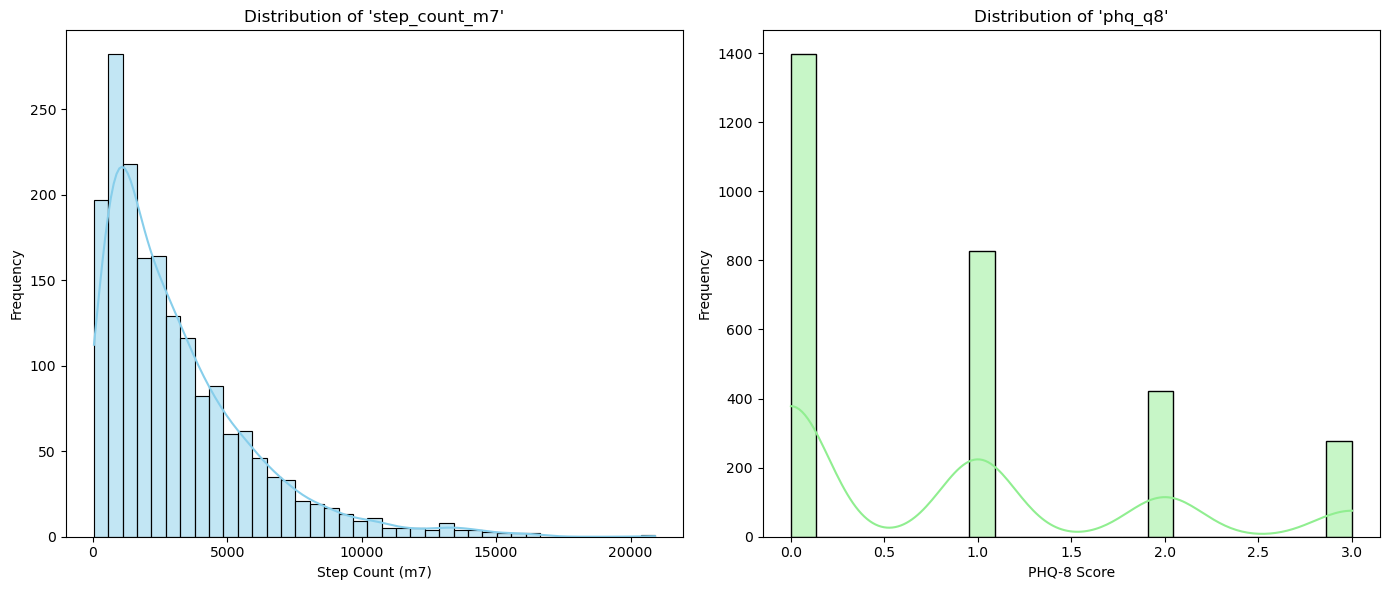

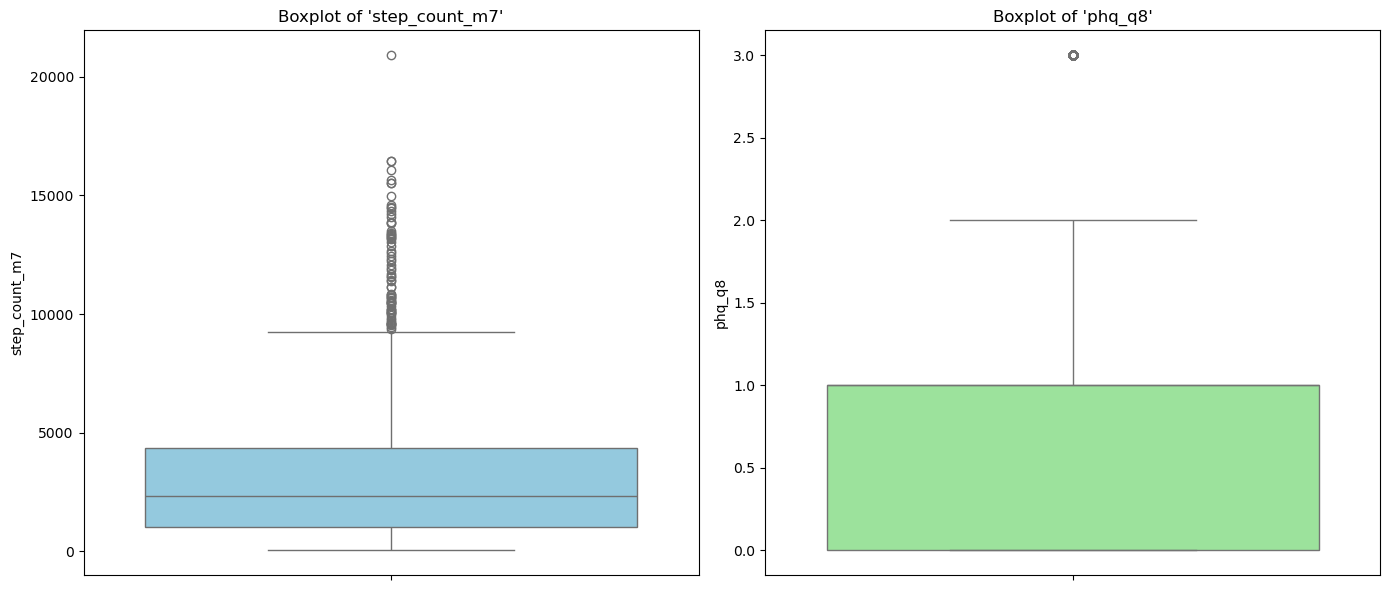

In [287]:


# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(df['step_count_m7'].dropna(), ax=axes[0], kde=True, color='skyblue')
axes[0].set_title("Distribution of 'step_count_m7'")
axes[0].set_xlabel('Step Count (m7)')
axes[0].set_ylabel('Frequency')

sns.histplot(df['phq_q8'].dropna(), ax=axes[1], kde=True, color='lightgreen')
axes[1].set_title("Distribution of 'phq_q8'")
axes[1].set_xlabel('PHQ-8 Score')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plot boxplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(y=df['step_count_m7'], ax=axes[0], color='skyblue')
axes[0].set_title("Boxplot of 'step_count_m7'")

sns.boxplot(y=df['phq_q8'], ax=axes[1], color='lightgreen')
axes[1].set_title("Boxplot of 'phq_q8'")

plt.tight_layout()
plt.show()


In [288]:
df.step_count_m7.describe()

count     1810.000000
mean      3126.063931
std       2819.509742
min         39.571429
25%       1036.642857
50%       2339.714286
75%       4358.857143
max      20911.142857
Name: step_count_m7, dtype: float64

In [289]:
# Calculate the correlation coefficient
correlation = df['step_count_m7'].corr(df['phq_q8'])

# Print the correlation coefficient
print(f"The correlation between step_count_m7 and phq_q8 is: {correlation}")

The correlation between step_count_m7 and phq_q8 is: 0.05290695074260494


Pearson correlation coefficient between the step_count_m7 (step count in the past 7 days) and phq_q8 (score on the 8th question of the Patient Health Questionnaire, likely related to depression or mental health) is approximately 0.053.

Positive Correlation: The value is positive (0.053), which indicates a positive correlation. This means that, in general, as step_count_m7 increases, phq_q8 also tends to increase, and vice versa.

Weak Correlation: The correlation coefficient is close to 0. The closer the correlation is to 0, the weaker the linear relationship. A value of 0.053 is considered a very weak positive correlation.

A correlation of 0.053 suggests that there is a minimal positive linear relationship between step count and the phq_q8 score. Increasing step count has a very, very slight tendency to be associated with a slightly higher score on phq_q8, but the relationship is so weak that it's not practically meaningful on its own. You would not be able to reliably predict someone's phq_q8 score based on their step_count_m7 with this correlation.

In [290]:
import plotly.express as px


# Create the scatter plot using plotly express
fig = px.scatter(df, x='step_count_m7', y='phq_q8',
                 title='Scatter Plot of step_count_m7 vs phq_q8',
                 labels={'step_count_m7': 'Step Count (Past 7 Days)',
                         'phq_q8': 'PHQ-Q8 Score'})  # Adding labels for clarity
fig.show()


Lack of Clear Trend: The most striking feature is the absence of a strong or obvious trend. The points don't seem to cluster around a line or curve. This visually confirms the weak correlation (0.0529) you calculated earlier.

The PHQ-Q8 scores appear to be taking on only a few discrete values (0, 1, 2, and 3), which is common for survey or questionnaire data where responses are often on a Likert scale or a limited set of choices. This is important because it means PHQ-Q8 isn't a truly continuous variable in this case, which can affect the interpretation of the Pearson correlation.

# Due to the discrete nature of phq_q8 limits the usefulness of the Pearson correlation coefficient. 
Hence we used some alternative approaches to explore the relationship between step_count_m7 and phq_q8, given that phq_q8 is essentially an ordinal categorical variable:

1. Stratified Analysis & Summary Statistics:
    Calculate summary statistics (mean, median, standard deviation) of step_count_m7 for each phq_q8 value. This lets us to see if there are any systematic differences in step count across the different PHQ-Q8 groups.

In [291]:
import pandas as pd

# Group by 'phq_q8' and calculate descriptive statistics for 'step_count_m7'
grouped_stats = df.groupby('phq_q8')['step_count_m7'].describe()
grouped_stats

,count,mean,std,min,25%,50%,75%,max
phq_q8,,,,,,,,
0.0,907.0,3001.358167,2769.427318,54.000000,1019.357143,2182.714286,4102.071429,16460.571429
1.0,480.0,3138.414286,2770.768473,42.142857,1054.750000,2427.714286,4379.214286,20911.142857
2.0,253.0,3360.739695,3069.469626,39.571429,1022.714286,2525.000000,4655.142857,16431.714286
3.0,170.0,3407.281513,2814.741300,51.285714,1159.892857,2613.142857,4790.000000,13285.571429


1. count: This is the number of observations (people) that have that specific phq_q8 score. For example:

    1) 907 people have a phq_q8 score of 0.
    1) 480 people have a phq_q8 score of 1.
    1) 253 people have a phq_q8 score of 2.
    1) 170 people have a phq_q8 score of 3.

2. mean: This is the average step_count_m7 for people with that phq_q8 score. For example:

    1) People with phq_q8 = 0 have an average step_count_m7 of 3001.36.
    1) People with phq_q8 = 1 have an average step_count_m7 of 3138.41.
    1) People with phq_q8 = 2 have an average step_count_m7 of 3360.74.
    1) People with phq_q8 = 3 have an average step_count_m7 of 3407.28.

Looking at the "mean" values, there's a slight increasing trend in the average step count as the phq_q8 score increases (from 3001.36 to 3407.28). This reinforces the very weak positive correlation you calculated earlier.


3. The differences in means are relatively small. The difference between the lowest mean (3001.36 for phq_q8 = 0) and the highest mean (3407.28 for phq_q8 = 3) is only about 400 steps.

4. There's substantial overlap in the distributions. The standard deviations are large, meaning there's a lot of variability in step counts within each phq_q8 group. The quartiles (25%, 50%, 75%) also show considerable overlap, indicating that people with different phq_q8 scores can have similar step counts.

In [292]:
import pandas as pd
import plotly.express as px

# Calculate means
mean_steps = df.groupby('phq_q8')['step_count_m7'].mean().reset_index()

# Create bar chart
fig = px.bar(mean_steps, x='phq_q8', y='step_count_m7',
             title='Mean Step Count by PHQ-Q8 Score',
             labels={'step_count_m7': 'Mean Step Count (Past 7 Days)',
                     'phq_q8': 'PHQ-Q8 Score'},
             category_orders={"phq_q8": [0, 1, 2, 3]})  # Ensure correct ordering
fig.show()


In [293]:
import pandas as pd
import plotly.graph_objects as go

# Calculate means and standard deviations
summary_stats = df.groupby('phq_q8')['step_count_m7'].agg(['mean', 'std']).reset_index()

# Create error bar plot
fig = go.Figure(data=[go.Bar(
    x=summary_stats['phq_q8'],
    y=summary_stats['mean'],
    error_y=dict(type='data',  # value of error bar given in data coordinates
                 array=summary_stats['std'])
)])

fig.update_layout(
    title='Mean Step Count by PHQ-Q8 Score with Standard Deviation',
    xaxis_title='PHQ-Q8 Score',
    yaxis_title='Mean Step Count (Past 7 Days)'
)

fig.show()


1. Error Bar Plot

What it is: An error bar plot is a way to visualize data that includes both a measure of central tendency (like the mean) and a measure of variability (like the standard deviation or standard error). It's especially helpful when you want to compare the means of different groups while also showing how much the data within each group varies.

    1. Components:

        1. Bars: Each bar represents the average value (mean) of the step_count_m7 for a specific phq_q8 score. The height of the bar corresponds to the mean.

        2. Error Bars: The vertical lines extending above and below each bar are the "error bars." In this case, they represent the standard deviation. The length of the error bar indicates the amount of variability in the data. A longer error bar means there's more spread in the step_count_m7 values for that phq_q8 score.

    2. Interpretation of your Error Bar Plot:

        1. Means: The tops of the bars are all around the 3000-3500 steps range, indicating that the average step count is roughly similar for all phq_q8 scores. There's a very slight upward trend, as we've discussed, but it's subtle.

        2. Variability: This is the most important thing the error bars tell us! The error bars are quite large relative to the differences in the means. This means that the variation in step counts within each phq_q8 group is much greater than the variation between the groups. In other words, people with the same phq_q8 score have a wide range of step counts, and this range overlaps substantially with the range of step counts for people with different phq_q8 scores. This is why a linear model (using statsmodels.formula.api as sm) would be useful here.

    3. Conclusion: The error bar plot reinforces the idea that there's no strong relationship between phq_q8 and step_count_m7. While there might be a slight trend toward higher step counts for higher phq_q8 scores, the large variability makes this trend unreliable.

In [294]:
import plotly.express as px

fig = px.box(df, x='phq_q8', y='step_count_m7',
             title='Box Plots of Step Count vs PHQ-Q8 Score',
             labels={'step_count_m7': 'Step Count (Past 7 Days)',
                     'phq_q8': 'PHQ-Q8 Score'},
            category_orders={"phq_q8": [0, 1, 2, 3]}) # Ensure correct ordering
fig.show()


In [295]:
import statsmodels.formula.api as smf

def analyze(inf: str, target: str):
    # Drop rows with missing values in 'step_count_m7' or 'phq_q8'
    df_clean = df.dropna(subset=[inf, target])

    # Fit the linear regression model
    model = smf.ols(formula=f'{target} ~ {inf}', data=df_clean).fit()

    # Display the summary of the model
    return model.summary()

display(analyze('step_count_m7', 'phq_q8'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 phq_q8   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     5.075
Date:                Wed, 19 Feb 2025   Prob (F-statistic):             0.0244
Time:                        17:57:25   Log-Likelihood:                -2553.4
No. Observations:                1810   AIC:                             5111.
Df Residuals:                    1808   BIC:                             5122.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.7682      0.035     22.055      0.000       0.700       0.837
step_count_m7  1.864e-05   8.28e-06      2.253      0.024    2.41e-06    3.49e-05
==============================================================================
Omnibus:                      203.238   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              265.778
Skew:                           0.924   Prob(JB):                     1.94e-58
Kurtosis:                       2.671   Cond. No.                     6.29e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [296]:
df_check = df.dropna(subset=['step_count_m7', 'phq_q8'])[['step_count_m7', 'phq_q8']]
β0 =  0.7682
β1 = 0.00001864
df_check['phq_q8_pred'] = β0 + β1 * df_check['step_count_m7']

df_check

,step_count_m7,phq_q8,phq_q8_pred
2440,2168.857143,3.0,0.808627
2455,5562.571429,2.0,0.871886
2463,14097.142857,1.0,1.030971
2468,1616.428571,0.0,0.798330
2472,5855.000000,0.0,0.877337
...,...,...,...
5299,6643.142857,2.0,0.892028
5300,10787.857143,1.0,0.969286
5302,1495.285714,0.0,0.796072
5303,5857.714286,0.0,0.877388


In [297]:
(0.00001864 * 6000)

0.11184000000000001

simple linear regression:

phq_q8 = 𝛽0 + 𝛽1*(step_count_m7) + 𝜀

where
phq_q8 is your dependent variable (the outcome you want to predict).
step_count_m7 is your independent variable (the predictor).

#### The goal is to see how changes in step_count_m7 are associated with changes in phq_q8.

## Key Regression Output

1. Coefficients
    1) Intercept (β₀) = 0.7682 
        This is the predicted value of phq_q8 when step_count_m7 = 0.
    2) step_count_m7 (β₁) = 1.864e-05 (or 0.00001864) 
        means that for every one-unit increase in step_count_m7, the predicted value of phq_q8 increases by 0.00001864.
        This is a very small effect.
        
Scenario A: A person has step_count_m7 = 5000 

Predicted phq_q8 = 0.7682 + (0.00001864 × 5000)
= 0.7682 + 0.0932
= 0.86

Scenario B: A person has step_count_m7 = 6000.

Predicted phq_q8 = 0.7682 + (0.00001864 × 6000)
= 0.7682 + 0.11184
= 0.88004

So, increasing steps by 1000 (from 5000 to 6000) corresponds to a predicted increase of about 0.02 points in phq_q8 (0.88 − 0.86 = 0.02).

## R-squared (Coefficient of determination):
It is a statistical measure that represents the proportion of the variance for a dependent variable (in this case, phq_q8) that's explained by an independent variable (in this case, step_count_m7) in a regression model.


Here, we built a simple linear regression model to predict phq_q8 based on step_count_m7.
The R-squared value you obtain from this model is 0.003 (0.3%). This indicates that the step_count_m7 variable explains only 0.3% of the variability in the phq_q8 variable. In other words, the majority of the variability in phq_q8 is not explained by step_count_m7. This means that the model does not fit the data well and that other factors are likely influencing phq_q8 more significantly.

##### Consequence: 
The model has limited predictive power, and relying on it for accurate predictions would not be advisable. It suggests that step_count_m7 alone is not a strong predictor of phq_q8.



## F-statistic Explained
The F-statistic is a measure used in regression analysis to assess the overall significance of the model. Specifically, it tests the hypothesis that all regression coefficients are equal to zero (i.e., the model with no predictors is as good as the model with predictors).

Meaning, In regression analysis, the F-test is used to test the null hypothesis that all the regression coefficients (except the intercept) are equal to zero. This means that the independent variables in the model do not contribute to explaining the variability in the dependent variable.

1. Null Hypothesis (H0): All coefficients are zero (the model with predictors is no better than the model with no predictors).

2. Alternative Hypothesis (H1): At least one coefficient is not zero (the model with predictors is better than the model with no predictors).

##### Evaluating the F-statistic Value:
1. High F-statistic: Indicates strong evidence against the null hypothesis, suggesting that the model with predictors is significantly better than the model with no predictors.

2. Low F-statistic: Indicates weak evidence against the null hypothesis, suggesting that the model with predictors is not significantly better than the model with no predictors.

We have a dataset with variables step_count_m7 and phq_q8. You build a regression model to predict phq_q8 based on step_count_m7.

1. Null Hypothesis (H0): The coefficient for step_count_m7 is zero.

2. Alternative Hypothesis (H1): The coefficient for step_count_m7 is not zero.

If the F-test indicates that the null hypothesis can be rejected, it suggests that step_count_m7 significantly contributes to the model and improves the prediction of phq_q8.

the F-statistic is 5.075 with a corresponding p-value of 0.024. A p-value of 0.024 is less than the common significance level of 0.05, suggesting that,
1) we can reject the null hypothesis 
2) there is a statistically significant linear relationship between step_count_m7 and phq_q8.

However, the strength of that relationship is weak, as indicated by the low R-squared value.

## Condition Number 
The condition number is a measure used to evaluate the sensitivity of a regression model's output to changes in the input data. It provides insight into potential issues related to multicollinearity (when predictor variables are highly correlated) and scaling.

Example:
Here, in the current datafram (df) have a regression model with several predictor variables, including step_count_m7 and phq_q8. We calculated the condition number for this model and found that it is approximately 6.29e+03 (6,290).

### Ideal Value for Condition Number:
Low Condition Number (< 30): Indicates that the regression model is stable, and there is little to no multicollinearity or scaling issues. The model's predictions are not overly sensitive to changes in the input data.

High Condition Number (> 30): Indicates potential multicollinearity or scaling issues. The model's predictions may be unstable and sensitive to small changes in the input data.

### Impact of Low and High Condition Number Values:
#### Low Condition Number:
Example: Condition number = 10

Interpretation: The predictor variables in the regression model are not highly correlated, and the model does not have scaling issues. The predictions are stable and reliable.

Consequence: The model is likely to perform well, and the regression coefficients are not unduly influenced by small changes in the input data.

#### High Condition Number:

Example: Condition number = 6,290

Interpretation: The large condition number suggests potential multicollinearity or scaling issues. The predictor variables might be highly correlated, or there might be significant differences in the scale of the variables.

Consequence: The model's predictions may be unstable, and the regression coefficients might be unreliable. The model is sensitive to small changes in the input data, which can lead to large changes in the output.


# Final Verdict:

1. Practical Significance (Effect Size):
The slope (1.864×10⁻⁵) is extremely small, meaning that even large differences in step count lead to only very minor changes in the predicted phq_q8 score.
2. The R-squared value is 0.003, indicating that only about 0.3% of the variability in phq_q8 is explained by step_count_m7. This tells us that while there is a statistically detectable relationship, it is practically negligible.
3. Direction of Effect:
There is a positive relationship: as step_count_m7 increases, phq_q8 increases slightly.




1. Statistically Significant but Weak Relationship:
    1) Despite achieving statistical significance (p-value < 0.05), the low R-squared value demonstrates that step_count_m7 is not a strong predictor of phq_q8.
    
    2) The relationship exists but has minimal practical significance in explaining variations in phq_q8.

2. Potential Model Issues:
    1) The large condition number suggests that there may be scaling issues affecting the model's stability and the reliability of the coefficients.
    2) The dependence on a single predictor limits the explanatory power of the model.

3. Implications:
    1) For Prediction: Relying on step_count_m7 alone to predict phq_q8 would not yield accurate or reliable results.
    2) For Understanding: While there is a slight association, step_count_m7 does not meaningfully explain changes in phq_q8.


# Recommendations:

1. Explore Additional Variables:
    1) Include Other Predictors: Consider adding more variables that may influence phq_q8, such as demographic factors, other health metrics, or psychological assessments.
    
    2) Feature Selection: Use techniques like correlation analysis or domain expertise to select relevant variables.

2. Address Scaling Issues:
    1) Standardize Variables: Apply scaling methods (e.g., standardization or normalization) to bring variables to a similar scale.
    2) Log Transformation: If step_count_m7 has a wide range or skewed distribution, consider a logarithmic transformation to reduce scaling problems.

3. Assess Multicollinearity (if adding more predictors):
    1) Variance Inflation Factor (VIF): Calculate VIF for each predictor to detect multicollinearity.
    2) Remove or Combine Variables: If multicollinearity is present, remove or combine highly correlated predictors.

4. Model Evaluation:

    1) Residual Analysis: Examine residuals to check assumptions of linear regression (linearity, homoscedasticity, normality).
    2) Alternative Models: Explore other modeling approaches (e.g., multiple regression, polynomial regression, machine learning algorithms) that might capture non-linear relationships.

5. Data Quality and Collection:
    1) Increase Sample Size: A larger dataset can provide more reliable estimates.
    2) Data Integrity: Ensure that the data for step_count_m7 and phq_q8 is accurate and collected consistently.

In [298]:
# What happens looking at the 14 day mean?
display(analyze('step_count_m14', 'phq_q8'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 phq_q8   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     7.853
Date:                Wed, 19 Feb 2025   Prob (F-statistic):            0.00513
Time:                        17:57:25   Log-Likelihood:                -2310.0
No. Observations:                1639   AIC:                             4624.
Df Residuals:                    1637   BIC:                             4635.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.7387      0.037     19.710      0.000       0.665       0.812
step_count_m14  2.495e-05    8.9e-06      2.802      0.005    7.49e-06    4.24e-05
==============================================================================
Omnibus:                      185.741   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              245.470
Skew:                           0.936   Prob(JB):                     4.98e-54
Kurtosis:                       2.697   Cond. No.                     6.44e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
inf = 'step_count_m7'
target = 'phq_q8'

def get_binary_age(age_bucket: str):
    if '85' in age_bucket:
        return 'old'
    ub = int(age_bucket.strip().split('-')[-1])
    if ub < 45:
        return 'young'
    return 'old'

df_clean = df.dropna(subset=[inf, target, 'sex', 'age_bucket'])
df_clean['sex'] = df_clean.sex.astype(str)
df_clean['age_binary'] = df_clean.age_bucket.apply(get_binary_age).astype(str)

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\188079569.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\188079569.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [300]:
df_clean[['step_count_m7', 'sex', 'age_binary', 'phq_q8']]

,step_count_m7,sex,age_binary,phq_q8
2440,2168.857143,Female,old,3.0
2455,5562.571429,Female,young,2.0
2463,14097.142857,Female,young,1.0
2468,1616.428571,Female,young,0.0
2472,5855.000000,Male,young,0.0
...,...,...,...,...
5299,6643.142857,Female,young,2.0
5300,10787.857143,Male,young,1.0
5302,1495.285714,Female,young,0.0
5303,5857.714286,Male,young,0.0


In [301]:
#Final code 
import statsmodels.formula.api as smf

def get_binary_age(age_bucket: str):
    if '85' in age_bucket:
        return 'old'
    ub = int(age_bucket.strip().split('-')[-1])
    if ub < 45:
        return 'young'
    return 'old'

df['age_binary'] = df.age_bucket.apply(lambda x: None if pd.isnull(x) else get_binary_age(x))

def analyze(inf: str, target: str, df: pd.DataFrame):
    df_clean = df.dropna(subset=[inf, target, 'sex', 'age_binary'])
    # Drop 'Other' because data is so small.
    df_clean = df_clean[df_clean.sex != 'Other']
    df_clean['sex'] = df_clean.sex.astype(str)
    df_clean['age_binary'] = df_clean.age_binary.astype(str)
    
    # Fit the linear regression model
    model = smf.ols(formula=f'{target} ~ {inf} : C(sex) : C(age_binary)', data=df_clean).fit()

    # Display the summary of the model
    return model.summary()


print(analyze('step_count_m7', 'phq_q8', df))

                            OLS Regression Results                            
Dep. Variable:                 phq_q8   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     9.097
Date:                Wed, 19 Feb 2025   Prob (F-statistic):           2.83e-07
Time:                        17:57:26   Log-Likelihood:                -2537.9
No. Observations:                1810   AIC:                             5086.
Df Residuals:                    1805   BIC:                             5113.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

1. Explanation of Key Values:

    1. Dependent Variable: phq_q8 - This is the variable the model is trying to predict.

    2. R-squared: 0.020 - This value represents the proportion of variance in the dependent variable (phq_q8) that is explained by the independent variables in the model. In this case, 0.020 means that only 2.0% of the variance in phq_q8 is explained by step_count_m7, sex, and age_binary and their interactions. This is a very low value, indicating a poor model fit.

    3. Adjusted R-squared: 0.018 - The adjusted R-squared is similar to R-squared but penalizes the model for including unnecessary predictors. Since the Adjusted R-squared is very close to the R-squared, it suggests the independent variables included have minor value to the model.

    4. F-statistic: 9.097 - This is a test statistic that assesses the overall significance of the model. It tests the null hypothesis that all the coefficients of the independent variables are equal to zero. A higher F-statistic suggests that the model is more significant.

    4. Prob (F-statistic): 2.83e-07 (or 0.000000283) - This is the p-value associated with the F-statistic. It represents the probability of observing an F-statistic as large as (or larger than) the one calculated, if the null hypothesis were true (i.e., if all the coefficients were truly zero). Since this value is very small (much less than 0.05), the model is statistically significant overall. This means that at least one of the predictors in the model is significantly related to phq_q8. However, remember that a significant p-value doesn't tell you which predictors are significant or how strong the relationship is. It only tells you that the model as a whole is better than a model with no predictors.

    
    
    4. coef: These are the estimated coefficients for each variable in the model. They represent the change in the dependent variable (phq_q8) for a one-unit change in the independent variable, holding all other variables constant. The coefficients are in scientific notation (e.g., -2.343e-05 means -2.343 x 10^-5).
        Intercept: 0.7707

        step_count_m7:C(sex)[Female]:C(age_binary)[old]: -2.343e-05, p-value = 0.094. This interaction term is not statistically significant (p > 0.05).

        step_count_m7:C(sex)[Male]:C(age_binary)[old]: -4.173e-05, 	p-value =  0.029. This interaction term is statistically significant (p < 0.05).

        step_count_m7:C(sex)[Female]:C(age_binary)[young]: 3.683e-05, p-value =  0.000. This interaction term is statistically significant (p < 0.05).

        step_count_m7:C(sex)[Male]:C(age_binary)[young]: 3.993e-05, p-value = 0.002. This interaction term is statistically significant (p < 0.05).

Cond. No.: 4.45e+03 - This is the condition number, which measures the sensitivity of the model to changes in the data. A high condition number (typically > 30) suggests that there may be multicollinearity (high correlation between independent variables) or other numerical problems that can make the model unstable and difficult to interpret. The note at the bottom of the image confirms this concern.


2. Quick "Before and After" Scenario

Let's create a hypothetical scenario to see how the model predicts phq_q8 changes:

Base Case:

    1. Female
    1. Old (age_binary = "old")
    1. step_count_m7 = 5000

phq_q8 = Intercept + (step_count_m7 * coefficient for Female & Old)

phq_q8 = 0.7707 + (5000 * -2.343e-05) = 0.7707 - 0.11715 = 0.65355

Scenario 1: Increase Step Count

    1. Female
    2. Old (age_binary = "old")
    3. step_count_m7 = 10000 (increased from 5000)

phq_q8 = 0.7707 + (10000 * -2.343e-05) = 0.7707 - 0.2343 = 0.5364


Base Case:

    1. Male
    1. Old (age_binary = "old")
    1. step_count_m7 = 5000

phq_q8 = Intercept + (step_count_m7 * coefficient for Male & Old)

phq_q8 = 0.7707 + (5000 * -4.173e-05) = 0.7707 -0.20865 = 0.56205

Scenario 1: Increase Step Count

    1. Male
    2. Old (age_binary = "old")
    3. step_count_m7 = 10000 (increased from 5000)

phq_q8 = 0.7707 + (10000 * -4.173e-05) = 0.7707 -0.4173 = 0.3534


1. Relationship: The model suggests that the relationship between step_count_m7 and phq_q8 depends on the combination of sex and age. 
    1. For example, for older females, there appears to be a slight negative relationship (higher step count is associated with slightly lower phq_q8), while for young females, there is a slight positive relationship.


## Final Verdict:
1. Despite achieving statistical significance (low p-value for the F-statistic), this model is not practically useful. Here's why:

2. Very Low R-squared: The model explains only 2% of the variance in phq_q8. This means that 98% of the variation in phq_q8 is due to other factors not included in the model.

3. Small Coefficients: The coefficients for the interaction terms are very small, indicating that changes in step count have a minimal impact on the predicted phq_q8 score.

4. Multicollinearity: The high condition number suggests that there may be multicollinearity, which can make the model unstable and difficult to interpret. The coefficients may not be reliably estimated.

# Key Takeaways:
The numbers show that only a very small part (1.8%) of the changes in PHQ-8 scores can be explained by these factors.
This means other things (like stress, sleep, or lifestyle) likely have a much bigger impact.

1. Older men who are more active tend to have slightly lower depression scores.
2. Younger women who are more active tend to have slightly higher depression scores.
3. For everyone else, activity time doesn’t seem to make much of a difference.

### Activity time is not a strong predictor of depression symptoms in this data.
### There might be other important factors affecting mental health that weren’t included in this study.


In [302]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
import pandas as pd

# Refit the model (important to use the same model specification)
model = smf.ols(formula=f'{target} ~ {inf} : C(sex) : C(age_binary)', data=df_clean).fit()

# Extract design matrix from the model
X = model.model.exog

# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data

""


In [303]:
vif_data["feature"] = model.model.exog_names  #gets the names of the independent variables in the model.

vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

In [304]:
vif_data

,feature,VIF
0,Intercept,2.254038
1,step_count_m7:C(sex)[Female]:C(age_binary)[old],1.132977
2,step_count_m7:C(sex)[Male]:C(age_binary)[old],1.038886
3,step_count_m7:C(sex)[Female]:C(age_binary)[young],1.174241
4,step_count_m7:C(sex)[Male]:C(age_binary)[young],1.097694


The table shows the VIF values for each term in your linear regression model. Remember that VIF measures how much the variance of an estimated regression coefficient increases if your predictors are correlated. A high VIF indicates a high degree of multicollinearity, which can make it difficult to interpret the coefficients and assess the importance of individual predictors.



Interpreting VIF Values:

    1. VIF = 1: No multicollinearity.
    2. 1 < VIF < 5: Moderate multicollinearity.
    3. VIF >= 5 or 10: High multicollinearity. This suggests that the coefficient estimates may be unreliable.

In our case, all the VIF values (excluding the intercept) are below 5, and most are very close to 1. This indicates that there is very little evidence of multicollinearity in your model. This contradicts the earlier warning based on the high condition number!

Why the Discrepancy?

The high condition number was a potential warning sign, but VIF provides a more specific and reliable assessment of multicollinearity. There are a few reasons why the condition number might be high even when VIF values are low:

Scaling Issues: The condition number is sensitive to the scaling of the variables. If the variables have very different scales (e.g., one variable ranges from 0 to 1, while another ranges from 1000 to 10000), this can inflate the condition number even if the variables are not highly correlated. The scaling issues might be the results of different values from step_count_m7, and the dummy variables.

Conclusion:

Based on the VIF values, you do not have a multicollinearity problem in your model. Therefore, you don't need to take any specific actions to address multicollinearity (such as removing variables).

## Important Note: 
Even though you don't have multicollinearity, remember that your model still has a very low R-squared (0.020), meaning it doesn't explain much of the variance in phq_q8. The low R-squared is more concerning than a multicollinearity issue because it indicates that the model is simply not capturing the important factors that influence phq_q8. Therefore, it's important to keep working on improving the model.

In [305]:
import numpy as np
import pandas as pd
import plotly.express as px

def plot_actual_vs_predicted(model, df_clean, target):
    # Get the actual and predicted values
    df_clean['predicted'] = model.fittedvalues
    df_clean['sex_age'] = (df_clean['sex'] + '|' + df_clean['age_binary']).apply(lambda x: x.lower())

    # Add jitter to the actual target values
    jitter = np.random.normal(0, 0.075, size=len(df_clean[target]))
    df_clean[f'{target}_jittered'] = df_clean[target] + jitter

    # Generate the scatter plot with hue using Plotly Express
    fig = px.scatter(df_clean, 
                     x=f'{target}_jittered', 
                     y='predicted', 
                     color='sex_age', 
                     title=f'Scatterplot of Actual vs Predicted {target} with Hue by Sex and Age',
                     labels={f'{target}_jittered': f'Actual {target} (Jittered)', 'predicted': f'Predicted {target}'},
                     opacity=0.5)

    fig.update_traces(marker=dict(size=10))  # Set marker size
    fig.show()

# Example usage
plot_actual_vs_predicted(model, df_clean, 'phq_q8')

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\2164224727.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\2164224727.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\2164224727.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

The plot suggests a poor model performance. There is no clear diagonal pattern. Instead, the predicted phq_q8 values seem to cluster around a narrow range between 0.6 and 1.0, regardless of the actual phq_q8 values. This indicates that the model does not accurately capture the variability in the actual phq_q8 scores.

The predicted values are not close to the actual values. The clustering of predicted values within a narrow range indicates that the model is underfitting the data and failing to make accurate predictions.
The model attempts to predict the actual values, but it does so very poorly. The limited range of predicted values and the lack of a diagonal pattern indicate that the model is not effective at predicting phq_q8.



1. Clustering of Predicted Values: The most prominent feature of the plot is the strong horizontal banding of the predicted values. Almost all data points have predicted phq_q8 values between approximately 0.6 and 1.0. This limited range of predicted values is a clear sign that the model is not sensitive to the actual differences in phq_q8 scores.

2. Lack of Diagonal Pattern: In a good regression model, you would expect to see the points clustered around a diagonal line going from the bottom-left to the top-right corner. This would indicate that the predicted values are close to the actual values. However, in this plot, there is no such pattern. The points are scattered randomly within the narrow band of predicted values.

3. Overlapping Groups: The different color-coded groups (representing sex and age combinations) are mixed together within the bands, without clear separation. This implies that the model is not effectively distinguishing between these groups in terms of predicting phq_q8.

4. Discrete Actual Values: Notice the "jittered" actual values are clustered around the whole numbers. This indicates that the original phq_q8 scores are discrete or ordinal (taking only integer values).

In [306]:
model.fittedvalues.min()

0.10006556033053715

In [307]:
model.fittedvalues.max()

1.3686580484520698

In [308]:
analyze('step_count_m7', 'phq_q8', df)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 phq_q8   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     9.097
Date:                Wed, 19 Feb 2025   Prob (F-statistic):           2.83e-07
Time:                        17:57:26   Log-Likelihood:                -2537.9
No. Observations:                1810   AIC:                             5086.
Df Residuals:                    1805   BIC:                             5113.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             0.7707      0.035     22.179      0.000       0.703       0.839
step_count_m7:C(sex)[Female]:C(age_binary)[old]   -2.343e-05    1.4e-05     -1.676      0.094   -5.09e-05    3.99e-06
step_count_m7:C(sex)[Male]:C(age_binary)[old]     -4.173e-05   1.91e-05     -2.181      0.029   -7.93e-05    -4.2e-06
step_count_m7:C(sex)[Female]:C(age_binary)[young]  3.683e-05      1e-05      3.671      0.000    1.72e-05    5.65e-05
step_count_m7:C(sex)[Male]:C(age_binary)[young]    3.993e-05   1.31e-05      3.039      0.002    1.42e-05    6.57e-05
==============================================================================
Omnibus:                      195.768   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              253.527
Skew:                           0.902   Prob(JB):                     8.86e-56
Kurtosis:                       2.678   Cond. No.                     4.45e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [309]:
import os

# Define your mappings
INF_MAPPING = {
    'sleep_start': 'Sleep',
    'sleep_end': 'Sleep',
    'sleep_duration': 'Sleep',
    'chronotype': 'Sleep',
    'sleep_routine_index': 'Routine',
    'time_at_home': 'Social',
    'num_location_clusters': 'Social',
    'loc_entropy': 'Social',
    'device_use_percent': 'Attention',
    'active_time': 'Activity',
    'activity_percent': 'Activity',
    'step_count': 'Activity',
    'walking_rate': 'Activity',
    'steps_relative_amplitude': 'Routine',
}

CATEGORY_QUESTION_MAPPING = {
    'Attention': ['phq_q7'],
    'Activity': ['phq_q8'],
    'Sleep': ['phq_q3'],
    'Social': ['phq_q1', 'phq_q6'],
    'Routine': ['phq_q3', 'phq_q5'],
}

TOTALS = ['phq2_total', 'phq8_total']

# Create a base output directory in the current working directory
output_dir = os.path.join(os.getcwd(), "outputs")
os.makedirs(output_dir, exist_ok=True)

# Save the DataFrame as a parquet file in the output directory.
# (Make sure that your DataFrame `df` is already defined.)
parquet_path = os.path.join(output_dir, 'data_proccessed.parquet')
df.to_parquet(parquet_path)
print(f"Saved parquet file to: {parquet_path}")

# Loop through each independent variable and target, run analysis, and log results
for inf, category in INF_MAPPING.items():
    for target in CATEGORY_QUESTION_MAPPING[category] + TOTALS:
        col = f'{inf}_m7'
        if col not in df.columns:
            print(f'Could not find {col}. Skipping...')
            continue

        # Run your analysis (assuming your analyze function returns a summary as a string)
        m = analyze(col, target, df)

        # Create directory structure for logging the results: outputs/ols/{category}/{col}/
        log_dir = os.path.join(output_dir, "ols", category, col)
        os.makedirs(log_dir, exist_ok=True)
        log_file = os.path.join(log_dir, f'{target}.txt')

        # Write the analysis summary to a text file
        with open(log_file, 'w') as f:
            f.write(str(m))
        print(f"Logged results for {col} in category {category} to {log_file}.")

Saved parquet file to: c:\Users\programming.com\Downloads\HR_Project\inferencing\outputs\data_proccessed.parquet
Logged results for sleep_start_m7 in category Sleep to c:\Users\programming.com\Downloads\HR_Project\inferencing\outputs\ols\Sleep\sleep_start_m7\phq_q3.txt.
Logged results for sleep_start_m7 in category Sleep to c:\Users\programming.com\Downloads\HR_Project\inferencing\outputs\ols\Sleep\sleep_start_m7\phq2_total.txt.
Logged results for sleep_start_m7 in category Sleep to c:\Users\programming.com\Downloads\HR_Project\inferencing\outputs\ols\Sleep\sleep_start_m7\phq8_total.txt.
Logged results for sleep_end_m7 in category Sleep to c:\Users\programming.com\Downloads\HR_Project\inferencing\outputs\ols\Sleep\sleep_end_m7\phq_q3.txt.
Logged results for sleep_end_m7 in category Sleep to c:\Users\programming.com\Downloads\HR_Project\inferencing\outputs\ols\Sleep\sleep_end_m7\phq2_total.txt.
Logged results for sleep_end_m7 in category Sleep to c:\Users\programming.com\Downloads\HR_Pr

Logged results for active_time_m7 in category Activity to c:\Users\programming.com\Downloads\HR_Project\inferencing\outputs\ols\Activity\active_time_m7\phq8_total.txt.
Logged results for activity_percent_m7 in category Activity to c:\Users\programming.com\Downloads\HR_Project\inferencing\outputs\ols\Activity\activity_percent_m7\phq_q8.txt.
Logged results for activity_percent_m7 in category Activity to c:\Users\programming.com\Downloads\HR_Project\inferencing\outputs\ols\Activity\activity_percent_m7\phq2_total.txt.
Logged results for activity_percent_m7 in category Activity to c:\Users\programming.com\Downloads\HR_Project\inferencing\outputs\ols\Activity\activity_percent_m7\phq8_total.txt.
Logged results for step_count_m7 in category Activity to c:\Users\programming.com\Downloads\HR_Project\inferencing\outputs\ols\Activity\step_count_m7\phq_q8.txt.
Logged results for step_count_m7 in category Activity to c:\Users\programming.com\Downloads\HR_Project\inferencing\outputs\ols\Activity\step

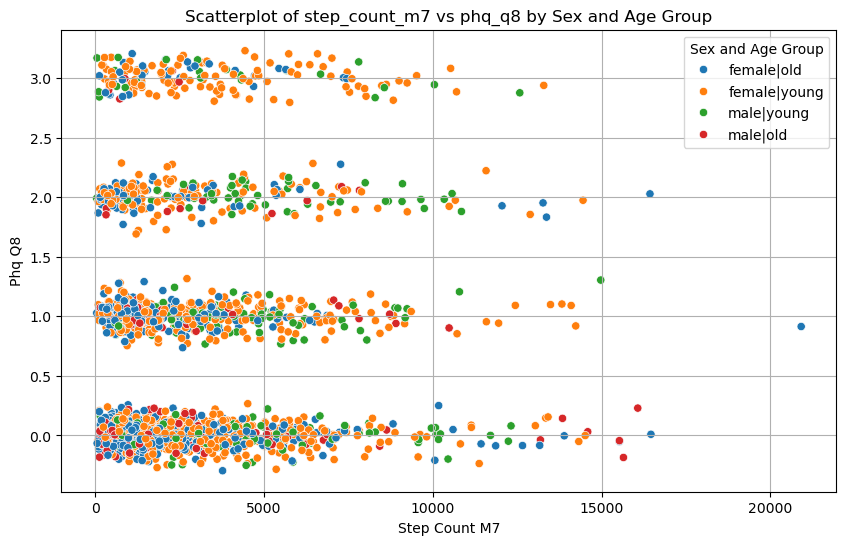

In [310]:

def create_scatterplot(input_col: str, target_col: str, jitter_strength: float = 0.1):
    # Clean the data
    df_clean = df.dropna(subset=[input_col, target_col, 'sex', 'age_binary'])
    df_clean = df_clean[df_clean.sex != 'Other']
    df_clean['sex'] = df_clean.sex.astype(str)
    df_clean['age_binary'] = df_clean.age_binary.astype(str)

    # Create a new column for the combination of sex and age_binary
    df_clean['sex_age'] = (df_clean['sex'] + '|' + df_clean['age_binary']).apply(lambda x: x.lower())

    # Add jitter to the target column
    df_clean[f'{target_col}_jitter'] = df_clean[target_col] + np.random.normal(0, jitter_strength, df_clean.shape[0])

    # Create the scatterplot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_clean, x=input_col, y=f'{target_col}_jitter', hue='sex_age')
    plt.title(f'Scatterplot of {input_col} vs {target_col} by Sex and Age Group')
    plt.xlabel(input_col.replace('_', ' ').title())
    plt.ylabel(target_col.replace('_', ' ').title())
    plt.legend(title='Sex and Age Group')
    plt.grid(True)
    plt.show()

# Example usage
create_scatterplot('step_count_m7', 'phq_q8')

Observations from the Scatter Plot

Horizontal Bands: The data points are arranged in distinct horizontal bands. This is because the 'phq_q8' scores are discrete, taking on only a few integer values (likely 0, 1, 2, and 3).

Overlapping Data Points: Within each band, there is significant overlap of the data points, making it difficult to discern any clear patterns or trends. This indicates a weak or non-existent relationship between 'step_count_m7' and 'phq_q8'.

Color Distribution: The colors (representing different sex and age groups) appear to be evenly distributed within each band. This suggests that the relationship between 'step_count_m7' and 'phq_q8' is similar across different sex and age groups.

Lack of Correlation: There is no clear upward or downward trend in the data. The points are scattered randomly within each band, indicating a lack of correlation between 'step_count_m7' and 'phq_q8'.

In [311]:
def clean_ethnicity(x):
    if not isinstance(x, (list, np.ndarray)):
        return None
    if len(x) < 2:
        return str(x[0])
    return 'Multiple'

df.ethnicity.apply(clean_ethnicity).astype(str)

2384    None
2385    None
2386    None
2387    None
2388    None
        ... 
5303    None
5304    None
5305    None
5306    None
5307    None
Name: ethnicity, Length: 2924, dtype: object

In [312]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tempfile
import os
import pandas as pd


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


def pd_read_parquet(artifact_path: str) -> pd.DataFrame:
    df = pd.read_parquet(artifact_path)
    return df


def get_binary_age(age_bucket: str):
    if '85' in age_bucket:
        return 'old'
    ub = int(age_bucket.strip().split('-')[-1])
    if ub < 45:
        return 'young'
    return 'old'

def clean_ethnicity(x):
    if not isinstance(x, (list, np.ndarray)):
        return None
    if len(x) < 2:
        return str(x[0])
    return 'Multiple'
    
def clean(input_col, target_col, df):
    df_clean = df.dropna(subset=[input_col, target_col, 'sex', 'age_binary'])
    df_clean['sex'] = df_clean.sex.astype(str)
    df_clean['age_binary'] = df_clean.age_binary.astype(str)

    # Create a new column for the combination of sex and age_binary
    df_clean['sex_age'] = (df_clean['sex'] + '|' + df_clean['age_binary']).apply(lambda x: x.lower())
    return df_clean

def create_scatterplot(input_col: str, target_col: str, df_clean, jitter_strength: float = 0.1):
    # Add jitter to the target column
    df_clean[f'{target_col}_jitter'] = df_clean[target_col] + np.random.normal(0, jitter_strength, df_clean.shape[0])

    # Create the scatterplot
    fig = plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_clean, x=input_col, y=f'{target_col}_jitter', hue='sex_age')
    plt.title(f'Scatterplot of {input_col} vs {target_col} by Sex and Age Group')
    plt.xlabel(input_col.replace('_', ' ').title())
    plt.ylabel(target_col.replace('_', ' ').title())
    plt.legend(title='Sex and Age Group')
    plt.grid(True)
    return fig

def analyze(inf: str, target: str, df_clean: pd.DataFrame):
    # Fit the linear regression model
    model = smf.ols(formula=f'{target} ~ {inf} : C(sex) : C(age_binary)', data=df_clean).fit()

    # Display the summary of the model
    return model

def plot_actual_vs_predicted(model, target, df_clean):
    # Get the actual and predicted values
    df_clean['predicted'] = model.fittedvalues

    # Add jitter to the actual target values
    jitter = np.random.normal(0, 0.075, size=len(df_clean[target]))
    df_clean[f'{target}_jittered'] = df_clean[target] + jitter

    # Generate the scatter plot with hue
    fig = plt.figure(figsize=(10, 6))
    sns.scatterplot(x=f'{target}_jittered', y='predicted', hue='sex_age', data=df_clean, alpha=0.5)
    plt.xlabel(f'Actual {target} (Jittered)')
    plt.ylabel(f'Predicted {target}')
    plt.title(f'Scatterplot of Actual vs Predicted {target} with Hue by Sex and Age')
    plt.grid(True)
    return fig

INF_MAPPING = {
    'sleep_start': 'Sleep',
    'sleep_end': 'Sleep',
    'sleep_duration': 'Sleep',
    'chronotype': 'Sleep',
    
    'sleep_routine_index': 'Routine',    
    'steps_relative_amplitude': 'Routine',
    
    'time_at_home': 'Social',
    'num_location_clusters': 'Social',
    'loc_entropy': 'Social',
    
    'device_use_percent': 'Attention',
    
    'active_time': 'Activity',
    'activity_percent': 'Activity',
    'step_count': 'Activity',
    'walking_rate': 'Activity',
}



CATEGORY_QUESTION_MAPPING = {
    'Attention': ['phq_q7'],
    'Activity': ['phq_q8'],
    'Sleep': ['phq_q3'],
    'Social': ['phq_q1', 'phq_q6'],
    'Routine': ['phq_q3', 'phq_q5'],
}

TOTALS = ['phq2_total', 'phq8_total']

DEMO_VARS = ['sex', 'age_bucket', 'ethnicity']

In [331]:
path = 'data (1).parquet'

df = pd_read_parquet(path)
df = df[df['deployment'] == 'hr-ascent-1']
df['sex'] = df.sex.astype(str)
df['age_binary'] = df.age_bucket.apply(lambda x: None if pd.isnull(x) else get_binary_age(x)).astype(str)
df['ethnicity'] = df.ethnicity.apply(clean_ethnicity).astype(str)
df = df.reset_index(drop=True)

# Setup Base Output Directory
base_output_dir = os.path.join(os.getcwd(), "all-deployments")
os.makedirs(base_output_dir, exist_ok=True)


# Log Descriptive Statistics
desc_stats = df.describe(include='all').to_string()
desc_stats_file = os.path.join(base_output_dir, "descriptive_statistics.txt")
with open(desc_stats_file, 'w') as f:
    f.write(desc_stats)
print("Logged descriptive statistics to:", desc_stats_file)


# Plot and Log Distributions for DEMO_VARS    
for var in DEMO_VARS:
    plt.figure(figsize=(10, 6))
    order = None
    if var == 'age_bucket':
        order = sorted(df[var].dropna().unique(), key=lambda x: int(x.split('-')[0]))
    sns.countplot(df, x=var, order=order)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var.replace('_', ' ').title())
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True)

    # Save the figure
    dist_dir = os.path.join(base_output_dir, "distributions")
    os.makedirs(dist_dir, exist_ok=True)
    dist_file = os.path.join(dist_dir, f'{var}.png')
    plt.savefig(dist_file, bbox_inches="tight")
    plt.close()
    print(f"Logged distribution plot for {var} at {dist_file}")

# -----------------------
# Plot and Log Correlation Heatmap
# -----------------------
plt.figure(figsize=(12, 10))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
heatmap_file = os.path.join(base_output_dir, 'correlation_heatmap.png')
plt.savefig(heatmap_file, bbox_inches="tight")
plt.close()
print("Logged correlation heatmap at:", heatmap_file)


# -----------------------
# For each variable in INF_MAPPING, run regression and create plots
# -----------------------
for inf, category in INF_MAPPING.items():
    col = f'{inf}_m7'
    if col not in df.columns:
        print(f'Could not find {col}. Skipping...')
        continue

    # Create a directory for this variable's outputs
    for target in CATEGORY_QUESTION_MAPPING[category] + TOTALS:
        # Clean the data for the current predictor (col) and target
        df_clean = clean(col, target, df)

        # Create and save the scatterplot
        fig_scatter = create_scatterplot(col, target, df_clean)
        scatter_dir = os.path.join(base_output_dir, "scatter", category, col)
        os.makedirs(scatter_dir, exist_ok=True)
        scatter_file = os.path.join(scatter_dir, f'{target}.png')
        fig_scatter.savefig(scatter_file, bbox_inches="tight")
        plt.close(fig_scatter)
        print(f"Logged scatterplot for {col} and target {target} at {scatter_file}")

        # Run the regression analysis and save the summary to a text file
        m = analyze(col, target, df_clean)
        ols_dir = os.path.join(base_output_dir, "ols", category, col)
        os.makedirs(ols_dir, exist_ok=True)
        regression_text_file = os.path.join(ols_dir, f'{target}.txt')
        with open(regression_text_file, 'w') as f:
            f.write(str(m.summary()))
        print(f"Logged regression results for {col} and target {target} at {regression_text_file}")

        # Create and save the actual vs predicted plot
        fig_pred = plot_actual_vs_predicted(m, target, df_clean)
        predicted_file = os.path.join(ols_dir, f'{target}_actual_vs_predicted.png')
        fig_pred.savefig(predicted_file, bbox_inches="tight")
        plt.close(fig_pred)
        print(f"Logged actual vs predicted plot for {col} and target {target} at {predicted_file}")

Logged descriptive statistics to: c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\descriptive_statistics.txt
Logged distribution plot for sex at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\distributions\sex.png
Logged distribution plot for age_bucket at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\distributions\age_bucket.png
Logged distribution plot for ethnicity at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\distributions\ethnicity.png
Logged correlation heatmap at: c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\correlation_heatmap.png
Logged scatterplot for sleep_start_m7 and target phq_q3 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Sleep\sleep_start_m7\phq_q3.png
Logged regression results for sleep_start_m7 and target phq_q3 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\o

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged actual vs predicted plot for sleep_start_m7 and target phq_q3 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Sleep\sleep_start_m7\phq_q3_actual_vs_predicted.png
Logged scatterplot for sleep_start_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Sleep\sleep_start_m7\phq2_total.png
Logged regression results for sleep_start_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Sleep\sleep_start_m7\phq2_total.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged actual vs predicted plot for sleep_start_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Sleep\sleep_start_m7\phq2_total_actual_vs_predicted.png
Logged scatterplot for sleep_start_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Sleep\sleep_start_m7\phq8_total.png
Logged regression results for sleep_start_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Sleep\sleep_start_m7\phq8_total.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged actual vs predicted plot for sleep_start_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Sleep\sleep_start_m7\phq8_total_actual_vs_predicted.png
Logged scatterplot for sleep_end_m7 and target phq_q3 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Sleep\sleep_end_m7\phq_q3.png
Logged regression results for sleep_end_m7 and target phq_q3 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Sleep\sleep_end_m7\phq_q3.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged actual vs predicted plot for sleep_end_m7 and target phq_q3 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Sleep\sleep_end_m7\phq_q3_actual_vs_predicted.png
Logged scatterplot for sleep_end_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Sleep\sleep_end_m7\phq2_total.png
Logged regression results for sleep_end_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Sleep\sleep_end_m7\phq2_total.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged actual vs predicted plot for sleep_end_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Sleep\sleep_end_m7\phq2_total_actual_vs_predicted.png
Logged scatterplot for sleep_end_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Sleep\sleep_end_m7\phq8_total.png
Logged regression results for sleep_end_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Sleep\sleep_end_m7\phq8_total.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged actual vs predicted plot for sleep_end_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Sleep\sleep_end_m7\phq8_total_actual_vs_predicted.png
Logged scatterplot for sleep_duration_m7 and target phq_q3 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Sleep\sleep_duration_m7\phq_q3.png
Logged regression results for sleep_duration_m7 and target phq_q3 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Sleep\sleep_duration_m7\phq_q3.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged actual vs predicted plot for sleep_duration_m7 and target phq_q3 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Sleep\sleep_duration_m7\phq_q3_actual_vs_predicted.png
Logged scatterplot for sleep_duration_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Sleep\sleep_duration_m7\phq2_total.png
Logged regression results for sleep_duration_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Sleep\sleep_duration_m7\phq2_total.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged actual vs predicted plot for sleep_duration_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Sleep\sleep_duration_m7\phq2_total_actual_vs_predicted.png
Logged scatterplot for sleep_duration_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Sleep\sleep_duration_m7\phq8_total.png
Logged regression results for sleep_duration_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Sleep\sleep_duration_m7\phq8_total.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged actual vs predicted plot for sleep_duration_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Sleep\sleep_duration_m7\phq8_total_actual_vs_predicted.png
Could not find chronotype_m7. Skipping...
Logged scatterplot for sleep_routine_index_m7 and target phq_q3 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Routine\sleep_routine_index_m7\phq_q3.png


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged regression results for sleep_routine_index_m7 and target phq_q3 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Routine\sleep_routine_index_m7\phq_q3.txt
Logged actual vs predicted plot for sleep_routine_index_m7 and target phq_q3 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Routine\sleep_routine_index_m7\phq_q3_actual_vs_predicted.png


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged scatterplot for sleep_routine_index_m7 and target phq_q5 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Routine\sleep_routine_index_m7\phq_q5.png
Logged regression results for sleep_routine_index_m7 and target phq_q5 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Routine\sleep_routine_index_m7\phq_q5.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Logged actual vs predicted plot for sleep_routine_index_m7 and target phq_q5 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Routine\sleep_routine_index_m7\phq_q5_actual_vs_predicted.png
Logged scatterplot for sleep_routine_index_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Routine\sleep_routine_index_m7\phq2_total.png
Logged regression results for sleep_routine_index_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Routine\sleep_routine_index_m7\phq2_total.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged actual vs predicted plot for sleep_routine_index_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Routine\sleep_routine_index_m7\phq2_total_actual_vs_predicted.png
Logged scatterplot for sleep_routine_index_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Routine\sleep_routine_index_m7\phq8_total.png
Logged regression results for sleep_routine_index_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Routine\sleep_routine_index_m7\phq8_total.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged actual vs predicted plot for sleep_routine_index_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Routine\sleep_routine_index_m7\phq8_total_actual_vs_predicted.png


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged scatterplot for steps_relative_amplitude_m7 and target phq_q3 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Routine\steps_relative_amplitude_m7\phq_q3.png
Logged regression results for steps_relative_amplitude_m7 and target phq_q3 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Routine\steps_relative_amplitude_m7\phq_q3.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Logged actual vs predicted plot for steps_relative_amplitude_m7 and target phq_q3 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Routine\steps_relative_amplitude_m7\phq_q3_actual_vs_predicted.png


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged scatterplot for steps_relative_amplitude_m7 and target phq_q5 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Routine\steps_relative_amplitude_m7\phq_q5.png
Logged regression results for steps_relative_amplitude_m7 and target phq_q5 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Routine\steps_relative_amplitude_m7\phq_q5.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Logged actual vs predicted plot for steps_relative_amplitude_m7 and target phq_q5 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Routine\steps_relative_amplitude_m7\phq_q5_actual_vs_predicted.png


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged scatterplot for steps_relative_amplitude_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Routine\steps_relative_amplitude_m7\phq2_total.png
Logged regression results for steps_relative_amplitude_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Routine\steps_relative_amplitude_m7\phq2_total.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Logged actual vs predicted plot for steps_relative_amplitude_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Routine\steps_relative_amplitude_m7\phq2_total_actual_vs_predicted.png
Logged scatterplot for steps_relative_amplitude_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Routine\steps_relative_amplitude_m7\phq8_total.png


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged regression results for steps_relative_amplitude_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Routine\steps_relative_amplitude_m7\phq8_total.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Logged actual vs predicted plot for steps_relative_amplitude_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Routine\steps_relative_amplitude_m7\phq8_total_actual_vs_predicted.png
Logged scatterplot for time_at_home_m7 and target phq_q1 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Social\time_at_home_m7\phq_q1.png
Logged regression results for time_at_home_m7 and target phq_q1 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Social\time_at_home_m7\phq_q1.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged actual vs predicted plot for time_at_home_m7 and target phq_q1 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Social\time_at_home_m7\phq_q1_actual_vs_predicted.png
Logged scatterplot for time_at_home_m7 and target phq_q6 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Social\time_at_home_m7\phq_q6.png


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged regression results for time_at_home_m7 and target phq_q6 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Social\time_at_home_m7\phq_q6.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Logged actual vs predicted plot for time_at_home_m7 and target phq_q6 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Social\time_at_home_m7\phq_q6_actual_vs_predicted.png
Logged scatterplot for time_at_home_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Social\time_at_home_m7\phq2_total.png


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged regression results for time_at_home_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Social\time_at_home_m7\phq2_total.txt
Logged actual vs predicted plot for time_at_home_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Social\time_at_home_m7\phq2_total_actual_vs_predicted.png


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged scatterplot for time_at_home_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Social\time_at_home_m7\phq8_total.png
Logged regression results for time_at_home_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Social\time_at_home_m7\phq8_total.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Logged actual vs predicted plot for time_at_home_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Social\time_at_home_m7\phq8_total_actual_vs_predicted.png
Logged scatterplot for num_location_clusters_m7 and target phq_q1 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Social\num_location_clusters_m7\phq_q1.png
Logged regression results for num_location_clusters_m7 and target phq_q1 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Social\num_location_clusters_m7\phq_q1.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged actual vs predicted plot for num_location_clusters_m7 and target phq_q1 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Social\num_location_clusters_m7\phq_q1_actual_vs_predicted.png
Logged scatterplot for num_location_clusters_m7 and target phq_q6 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Social\num_location_clusters_m7\phq_q6.png
Logged regression results for num_location_clusters_m7 and target phq_q6 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Social\num_location_clusters_m7\phq_q6.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged actual vs predicted plot for num_location_clusters_m7 and target phq_q6 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Social\num_location_clusters_m7\phq_q6_actual_vs_predicted.png
Logged scatterplot for num_location_clusters_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Social\num_location_clusters_m7\phq2_total.png
Logged regression results for num_location_clusters_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Social\num_location_clusters_m7\phq2_total.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged actual vs predicted plot for num_location_clusters_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Social\num_location_clusters_m7\phq2_total_actual_vs_predicted.png


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged scatterplot for num_location_clusters_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Social\num_location_clusters_m7\phq8_total.png
Logged regression results for num_location_clusters_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Social\num_location_clusters_m7\phq8_total.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Logged actual vs predicted plot for num_location_clusters_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Social\num_location_clusters_m7\phq8_total_actual_vs_predicted.png
Logged scatterplot for loc_entropy_m7 and target phq_q1 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Social\loc_entropy_m7\phq_q1.png


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged regression results for loc_entropy_m7 and target phq_q1 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Social\loc_entropy_m7\phq_q1.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Logged actual vs predicted plot for loc_entropy_m7 and target phq_q1 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Social\loc_entropy_m7\phq_q1_actual_vs_predicted.png


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged scatterplot for loc_entropy_m7 and target phq_q6 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Social\loc_entropy_m7\phq_q6.png
Logged regression results for loc_entropy_m7 and target phq_q6 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Social\loc_entropy_m7\phq_q6.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Logged actual vs predicted plot for loc_entropy_m7 and target phq_q6 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Social\loc_entropy_m7\phq_q6_actual_vs_predicted.png
Logged scatterplot for loc_entropy_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Social\loc_entropy_m7\phq2_total.png


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged regression results for loc_entropy_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Social\loc_entropy_m7\phq2_total.txt
Logged actual vs predicted plot for loc_entropy_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Social\loc_entropy_m7\phq2_total_actual_vs_predicted.png


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged scatterplot for loc_entropy_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Social\loc_entropy_m7\phq8_total.png
Logged regression results for loc_entropy_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Social\loc_entropy_m7\phq8_total.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Logged actual vs predicted plot for loc_entropy_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Social\loc_entropy_m7\phq8_total_actual_vs_predicted.png
Logged scatterplot for device_use_percent_m7 and target phq_q7 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Attention\device_use_percent_m7\phq_q7.png


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged regression results for device_use_percent_m7 and target phq_q7 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Attention\device_use_percent_m7\phq_q7.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Logged actual vs predicted plot for device_use_percent_m7 and target phq_q7 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Attention\device_use_percent_m7\phq_q7_actual_vs_predicted.png
Logged scatterplot for device_use_percent_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Attention\device_use_percent_m7\phq2_total.png


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged regression results for device_use_percent_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Attention\device_use_percent_m7\phq2_total.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Logged actual vs predicted plot for device_use_percent_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Attention\device_use_percent_m7\phq2_total_actual_vs_predicted.png
Logged scatterplot for device_use_percent_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Attention\device_use_percent_m7\phq8_total.png


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged regression results for device_use_percent_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Attention\device_use_percent_m7\phq8_total.txt
Logged actual vs predicted plot for device_use_percent_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Attention\device_use_percent_m7\phq8_total_actual_vs_predicted.png


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged scatterplot for active_time_m7 and target phq_q8 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Activity\active_time_m7\phq_q8.png
Logged regression results for active_time_m7 and target phq_q8 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Activity\active_time_m7\phq_q8.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Logged actual vs predicted plot for active_time_m7 and target phq_q8 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Activity\active_time_m7\phq_q8_actual_vs_predicted.png
Logged scatterplot for active_time_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Activity\active_time_m7\phq2_total.png
Logged regression results for active_time_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Activity\active_time_m7\phq2_total.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged actual vs predicted plot for active_time_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Activity\active_time_m7\phq2_total_actual_vs_predicted.png
Logged scatterplot for active_time_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Activity\active_time_m7\phq8_total.png
Logged regression results for active_time_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Activity\active_time_m7\phq8_total.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged actual vs predicted plot for active_time_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Activity\active_time_m7\phq8_total_actual_vs_predicted.png
Logged scatterplot for activity_percent_m7 and target phq_q8 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Activity\activity_percent_m7\phq_q8.png
Logged regression results for activity_percent_m7 and target phq_q8 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Activity\activity_percent_m7\phq_q8.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged actual vs predicted plot for activity_percent_m7 and target phq_q8 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Activity\activity_percent_m7\phq_q8_actual_vs_predicted.png
Logged scatterplot for activity_percent_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Activity\activity_percent_m7\phq2_total.png
Logged regression results for activity_percent_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Activity\activity_percent_m7\phq2_total.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged actual vs predicted plot for activity_percent_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Activity\activity_percent_m7\phq2_total_actual_vs_predicted.png
Logged scatterplot for activity_percent_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Activity\activity_percent_m7\phq8_total.png
Logged regression results for activity_percent_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Activity\activity_percent_m7\phq8_total.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged actual vs predicted plot for activity_percent_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Activity\activity_percent_m7\phq8_total_actual_vs_predicted.png
Logged scatterplot for step_count_m7 and target phq_q8 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Activity\step_count_m7\phq_q8.png
Logged regression results for step_count_m7 and target phq_q8 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Activity\step_count_m7\phq_q8.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged actual vs predicted plot for step_count_m7 and target phq_q8 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Activity\step_count_m7\phq_q8_actual_vs_predicted.png
Logged scatterplot for step_count_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Activity\step_count_m7\phq2_total.png
Logged regression results for step_count_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Activity\step_count_m7\phq2_total.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged actual vs predicted plot for step_count_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Activity\step_count_m7\phq2_total_actual_vs_predicted.png
Logged scatterplot for step_count_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Activity\step_count_m7\phq8_total.png
Logged regression results for step_count_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Activity\step_count_m7\phq8_total.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged actual vs predicted plot for step_count_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Activity\step_count_m7\phq8_total_actual_vs_predicted.png
Logged scatterplot for walking_rate_m7 and target phq_q8 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Activity\walking_rate_m7\phq_q8.png
Logged regression results for walking_rate_m7 and target phq_q8 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Activity\walking_rate_m7\phq_q8.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged actual vs predicted plot for walking_rate_m7 and target phq_q8 at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Activity\walking_rate_m7\phq_q8_actual_vs_predicted.png


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged scatterplot for walking_rate_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Activity\walking_rate_m7\phq2_total.png
Logged regression results for walking_rate_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Activity\walking_rate_m7\phq2_total.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Logged actual vs predicted plot for walking_rate_m7 and target phq2_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Activity\walking_rate_m7\phq2_total_actual_vs_predicted.png


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Logged scatterplot for walking_rate_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\scatter\Activity\walking_rate_m7\phq8_total.png
Logged regression results for walking_rate_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Activity\walking_rate_m7\phq8_total.txt


C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\programming.com\AppData\Local\Temp\ipykernel_8704\861151474.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Logged actual vs predicted plot for walking_rate_m7 and target phq8_total at c:\Users\programming.com\Downloads\HR_Project\inferencing\all-deployments\ols\Activity\walking_rate_m7\phq8_total_actual_vs_predicted.png


In [338]:
begin = 'major_'

major_columns = [col for col in df.columns if col.startswith(begin)]

df[major_columns]

""
0
1
2
3
4
...
2919
2920
2921
2922


In [339]:
keywords = ["major", "depressive", "disorder"]

# Get the columns whose names contain any of the keywords
filtered_columns = [col for col in df.columns if any(keyword in col for keyword in keywords)]

# Create a new DataFrame with only those columns
df[filtered_columns]

""
0
1
2
3
4
...
2919
2920
2921
2922


# active_time_m7

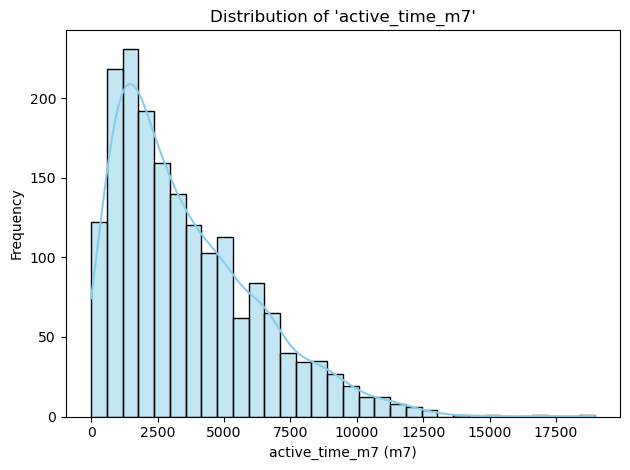

In [410]:
sns.histplot(df['active_time_m7'].dropna(),  kde=True, color='skyblue')
plt.title("Distribution of 'active_time_m7'")
plt.xlabel('active_time_m7 (m7)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

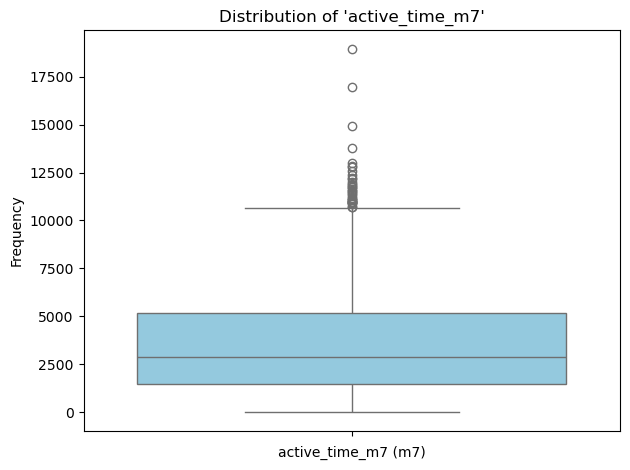

In [426]:
sns.boxplot(df['active_time_m7'].dropna(), color='skyblue')
plt.title("Distribution of 'active_time_m7'")
plt.xlabel('active_time_m7 (m7)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [401]:
df.active_time_m7.describe()

count     1810.000000
mean      3585.581441
std       2697.679435
min          0.000000
25%       1473.500000
50%       2891.071428
75%       5168.571429
max      18960.000000
Name: active_time_m7, dtype: float64

1. Right Skewness: Both the statistical summary (mean > median) and the distribution plot confirm the data is right-skewed. In the distribution plot, most bars are concentrated toward the left side, creating a long right tail. The long tail is where the data is said to be skewed to. This indicates that while most individuals have lower average daily walking times, a smaller number have significantly higher times.

2. Main Peak and Frequency: Based on the histogram, the data has a right skew where the distribution is more concentrated at the lower end of the walking time range. A lot of data has below 2500.

1. Most people don't move a lot: The biggest bar is on the left side of the chart, meaning lots of people have low "active_time_m7" values. Most move for shorter time of the day.

1. Few People Walk Alot: As we go to the right, towards higher "active_time_m7" values, the bars get smaller. That means fewer and fewer people have really high average walking times. It gets rare to find someone who walks multiple hours per day, every day.

1. Some People Are Sedentary: This chart says that there are a group of people who do not do walk at all.

### Real-life Conclusions:

1. The "average" can be misleading: This graph shows that the average (mean) may not accurately represent the walking habits of most people, because the data is positively skewed. The small number of very active people may skew the average upward. So, it would be best to measure people with smaller "active_time_m7".

2. There's a wide range of activity levels: The long tail on the right side tells us that there's a huge difference in how much different people move during the day, because there is some people with high "active_time_m7".

In [341]:
def classify_phq(score):
    if 0 <= score <= 4:
        return 'Minimal Depression'
    elif 5 <= score <= 9:
        return 'Mild Depression'
    elif 10 <= score <= 14:
        return 'Moderate Depression'
    elif 15 <= score <= 19:
        return 'Moderately Severe Depression'
    elif 20 <= score <= 27:
        return 'Severe Depression'
    else:
        return 'Invalid Score'

def classify_ethnicity(ethnicity_val):
    if ethnicity_val == 'White':
        return True
   # elif ethnicity_val == 'None':
    #    return 'Declined'
    else:
        return False

'''def major_depressive_disorder(score):
    if 0 <= score <= 14:
        return False
    elif 15 <= score <= 27:
        return True
    else:
        return 'Invalid Disorder '''


# Apply the classification function to the phq_total column
df['ethnicity_white'] = df['ethnicity'].apply(classify_ethnicity)

# Apply the classification function to the phq_total column
df['phq_category'] = df['phq9_total'].apply(classify_phq)

# Apply the classification function to the phq_total column
#df['major_depressive_disorder'] = df['phq9_total'].apply(major_depressive_disorder)


# Specify the category order for phq_category
category_order = ['Minimal Depression', 'Mild Depression', 'Moderate Depression', 'Moderately Severe Depression', 'Severe Depression']
df['phq_category'] = pd.Categorical(df['phq_category'], categories=category_order, ordered=True)

In [342]:
data =  ['active_time_m7', 'age_bucket', 'phq_category', 'ethnicity_white', 'gender', 'phq9_total',] # 'major_depressive_disorder']
df_clean= df[data].dropna(subset=data)
df_clean.head()

,active_time_m7,age_bucket,phq_category,ethnicity_white,gender,phq9_total
56,1731.428571,45-54,Severe Depression,False,Woman,21.0
71,4870.714286,18-24,Severe Depression,False,Woman,21.0
79,9025.714286,35-44,Severe Depression,False,Woman,22.0
84,2565.428571,35-44,Minimal Depression,True,Woman,0.0
88,6077.142857,18-24,Moderate Depression,True,Man,12.0


In [343]:
import plotly.graph_objects as go
from statsmodels.distributions.empirical_distribution import ECDF

# Example list of age buckets (ensure these exist in your DataFrame)
age_buckets = ['16-18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84']

# Create a Plotly figure
fig = go.Figure()

# For each age bucket, filter the DataFrame and compute ECDF
for bucket in age_buckets:
    # Filter the DataFrame for the current age bucket
    sub_df = df[df['age_bucket'] == bucket]

    # If there are rows in this subgroup, compute and plot the ECDF
    if len(sub_df) > 0:
        # Drop any NaNs in active_time_m7
        values = sub_df['active_time_m7'].dropna()

        # Compute the ECDF using statsmodels
        ecdf = ECDF(values)
        
        # ecdf.x are the sorted data points, ecdf.y are the cumulative probabilities
        x_vals = ecdf.x
        y_vals = ecdf.y
        
        # Add a line trace to the figure for this age bucket
        fig.add_trace(
            go.Scatter(
                x=x_vals,
                y=y_vals,
                mode='lines',
                name=bucket
            )
        )

# Update layout to set titles and legends
fig.update_layout(
    title='ECDF of active_time_m7 by Age Bucket',
    xaxis_title='active_time_m7',
    yaxis_title='Proportion (ECDF)',
    legend_title='Age Bucket'
)

fig.show()


In [344]:
df.deployment.value_counts()

deployment
hr-ascent-1    2924
Name: count, dtype: int64

In [362]:
df['active_time_m7'].notna().sum()

1810

In [361]:
df['active_time_m7'].isna().sum()

1114

In [381]:
import plotly.graph_objects as go
from statsmodels.distributions.empirical_distribution import ECDF

# Example DataFrame: df_clean
# Must have columns: ["active_time_m7", "age_bucket", "phq_category", "ethnicity_white", "gender", "major_depressive_disorder"]

groupings = {
    'age_bucket': ['16-18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84'],
    'phq_category': ['Minimal Depression', 'Mild Depression', 'Moderate Depression',
                     'Moderately Severe Depression', 'Severe Depression'],
    'ethnicity_white': [True, False],
    'gender': ['Woman', 'Man', 'Transgender', 'Gender Queer Or Nonconforming',],
    #'major_depressive_disorder': ['Invalid Disorder', True, False]
}

for grouping_var, categories in groupings.items():
    # Create a new figure for each grouping
    fig = go.Figure()

    # For each category in this grouping, filter and plot the ECDF of active_time_m7
    for cat in categories:
        # Filter rows where the grouping_var matches cat
        sub_df = df[df[grouping_var] == cat]
        if sub_df.empty:
            continue
        
        # Drop any NaN values in active_time_m7
        values = sub_df['active_time_m7'].dropna()
        if values.empty:
            continue
        
        # Compute ECDF
        ecdf = ECDF(values)
        x_vals = ecdf.x
        y_vals = ecdf.y
        
        # Add a Scatter trace for this category
        fig.add_trace(
            go.Scatter(
                x=x_vals,
                y=y_vals,
                mode='lines',
                name=str(cat)  # This label shows in the legend
            )
        )
    
    # Update layout for this figure
    fig.update_layout(
        title=f"ECDF of active_time_m7 by {grouping_var}",
        xaxis_title="active_time_m7",
        yaxis_title="Proportion (ECDF)",
        legend_title=grouping_var,
        height=600,
        width=800
    )
    
    # Show (or save) the figure
    fig.show()


In [397]:
df[df.active_time_m7.notna()][['active_time_m7']].describe()

,active_time_m7
count,1810.000000
mean,3585.581441
std,2697.679435
min,0.000000
25%,1473.500000
50%,2891.071428
75%,5168.571429
max,18960.000000


# activity_percent_m7

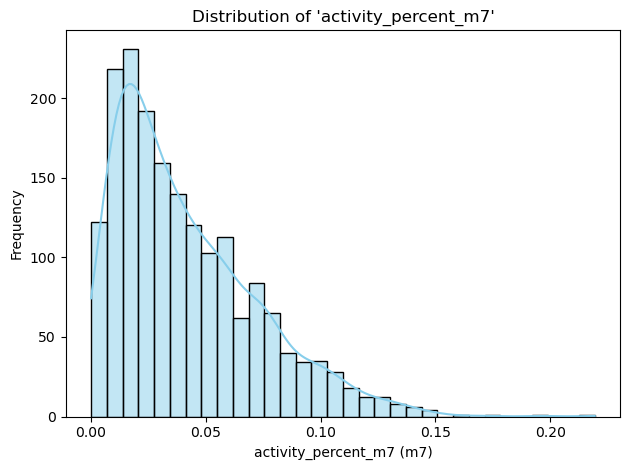

In [417]:
sns.histplot(df['activity_percent_m7'].dropna(),  kde=True, color='skyblue')
plt.title("Distribution of 'activity_percent_m7'")
plt.xlabel('activity_percent_m7 (m7)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [418]:
df.activity_percent_m7.describe()

count    1810.000000
mean        0.041500
std         0.031223
min         0.000000
25%         0.017054
50%         0.033461
75%         0.059821
max         0.219444
Name: activity_percent_m7, dtype: float64

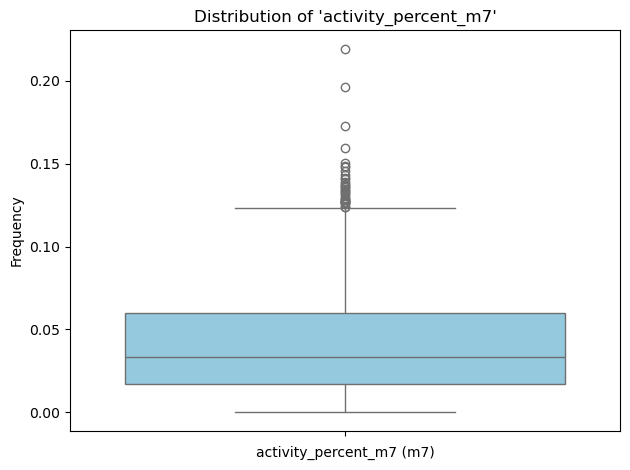

In [425]:
sns.boxplot(df['activity_percent_m7'].dropna(),   color='skyblue')
plt.title("Distribution of 'activity_percent_m7'")
plt.xlabel('activity_percent_m7 (m7)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [394]:
df.activity_percent_m7.isna().sum()

1114

In [398]:
df[df.active_time_m7.notna()][['activity_percent_m7']].describe()

,activity_percent_m7
count,1810.000000
mean,0.041500
std,0.031223
min,0.000000
25%,0.017054
50%,0.033461
75%,0.059821
max,0.219444


In [378]:
import plotly.graph_objects as go
from statsmodels.distributions.empirical_distribution import ECDF

# Example list of age buckets (ensure these exist in your DataFrame)
age_buckets = ['16-18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84']

# Create a Plotly figure
fig = go.Figure()

# For each age bucket, filter the DataFrame and compute ECDF
for bucket in age_buckets:
    # Filter the DataFrame for the current age bucket
    sub_df = df[df['age_bucket'] == bucket]

    # If there are rows in this subgroup, compute and plot the ECDF
    if len(sub_df) > 0:
        # Drop any NaNs in activity_percent_m7
        values = sub_df['activity_percent_m7'].dropna()

        # Compute the ECDF using statsmodels
        ecdf = ECDF(values)
        
        # ecdf.x are the sorted data points, ecdf.y are the cumulative probabilities
        x_vals = ecdf.x
        y_vals = ecdf.y
        
        # Add a line trace to the figure for this age bucket
        fig.add_trace(
            go.Scatter(
                x=x_vals,
                y=y_vals,
                mode='lines',
                name=bucket
            )
        )

# Update layout to set titles and legends
fig.update_layout(
    title='ECDF of activity_percent_m7 by Age Bucket',
    xaxis_title='activity_percent_m7',
    yaxis_title='Proportion (ECDF)',
    legend_title='Age Bucket'
)

fig.show()


In [380]:
import plotly.graph_objects as go
from statsmodels.distributions.empirical_distribution import ECDF

# Example DataFrame: df_clean
# Must have columns: ["activity_percent_m7", "age_bucket", "phq_category", "ethnicity_white", "gender", "major_depressive_disorder"]

groupings = {
    'age_bucket': ['16-18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84'],
    'phq_category': ['Minimal Depression', 'Mild Depression', 'Moderate Depression',
                     'Moderately Severe Depression', 'Severe Depression'],
    'ethnicity_white': [True, False],
    'gender': ['Woman', 'Man', 'Transgender', 'Gender Queer Or Nonconforming', ],
    #'major_depressive_disorder': ['Invalid Disorder', True, False]
}

for grouping_var, categories in groupings.items():
    # Create a new figure for each grouping
    fig = go.Figure()

    # For each category in this grouping, filter and plot the ECDF of activity_percent_m7
    for cat in categories:
        # Filter rows where the grouping_var matches cat
        sub_df = df[df[grouping_var] == cat]
        if sub_df.empty:
            continue
        
        # Drop any NaN values in activity_percent_m7
        values = sub_df['activity_percent_m7'].dropna()
        if values.empty:
            continue
        
        # Compute ECDF
        ecdf = ECDF(values)
        x_vals = ecdf.x
        y_vals = ecdf.y
        
        # Add a Scatter trace for this category
        fig.add_trace(
            go.Scatter(
                x=x_vals,
                y=y_vals,
                mode='lines',
                name=str(cat)  # This label shows in the legend
            )
        )
    
    # Update layout for this figure
    fig.update_layout(
        title=f"ECDF of activity_percent_m7 by {grouping_var}",
        xaxis_title="activity_percent_m7",
        yaxis_title="Proportion (ECDF)",
        legend_title=grouping_var,
        height=600,
        width=800
    )
    
    # Show (or save) the figure
    fig.show()


# step_count_m7

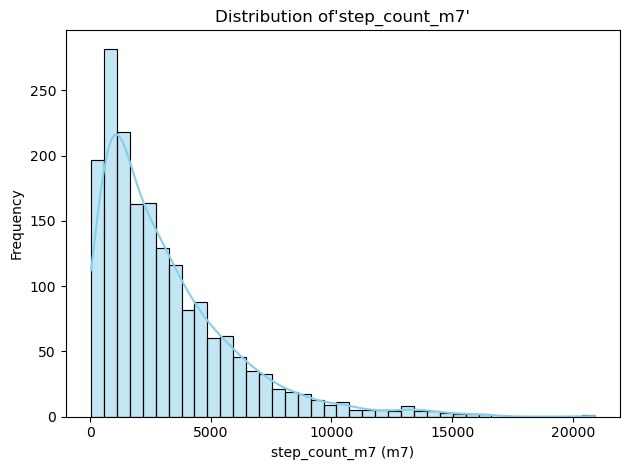

In [428]:
sns.histplot(df['step_count_m7'].dropna(),  kde=True, color='skyblue')
plt.title("Distribution of'step_count_m7'")
plt.xlabel('step_count_m7 (m7)')
plt.ylabel('Frequency')

plt.tight_layout()

In [429]:
df.step_count_m7.describe()

count     1810.000000
mean      3126.063931
std       2819.509742
min         39.571429
25%       1036.642857
50%       2339.714286
75%       4358.857143
max      20911.142857
Name: step_count_m7, dtype: float64

In [383]:
keyword= 'step'

a = [ col for col in df.columns if col.startswith(keyword)]
a 

['steps_least_active_5h_m7',
 'steps_least_active_5h_m14',
 'steps_least_active_5h_s7',
 'steps_least_active_5h_s14',
 'steps_most_active_10h_m7',
 'steps_most_active_10h_m14',
 'steps_most_active_10h_s7',
 'steps_most_active_10h_s14',
 'steps_relative_amplitude_m7',
 'steps_relative_amplitude_m14',
 'steps_relative_amplitude_s7',
 'steps_relative_amplitude_s14',
 'step_count_m7',
 'step_count_m14',
 'step_count_s7',
 'step_count_s14']

In [384]:
import plotly.graph_objects as go
from statsmodels.distributions.empirical_distribution import ECDF

# Example list of age buckets (ensure these exist in your DataFrame)
age_buckets = ['16-18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84']

# Create a Plotly figure
fig = go.Figure()

# For each age bucket, filter the DataFrame and compute ECDF
for bucket in age_buckets:
    # Filter the DataFrame for the current age bucket
    sub_df = df[df['age_bucket'] == bucket]

    # If there are rows in this subgroup, compute and plot the ECDF
    if len(sub_df) > 0:
        # Drop any NaNs in step_count_m7
        values = sub_df['step_count_m7'].dropna()

        # Compute the ECDF using statsmodels
        ecdf = ECDF(values)
        
        # ecdf.x are the sorted data points, ecdf.y are the cumulative probabilities
        x_vals = ecdf.x
        y_vals = ecdf.y
        
        # Add a line trace to the figure for this age bucket
        fig.add_trace(
            go.Scatter(
                x=x_vals,
                y=y_vals,
                mode='lines',
                name=bucket
            )
        )

# Update layout to set titles and legends
fig.update_layout(
    title='ECDF of step_count_m7 by Age Bucket',
    xaxis_title='step_count_m7',
    yaxis_title='Proportion (ECDF)',
    legend_title='Age Bucket'
)

fig.show()


In [385]:
import plotly.graph_objects as go
from statsmodels.distributions.empirical_distribution import ECDF

# Example DataFrame: df_clean
# Must have columns: ["step_count_m7", "age_bucket", "phq_category", "ethnicity_white", "gender", "major_depressive_disorder"]

groupings = {
    'age_bucket': ['16-18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84'],
    'phq_category': ['Minimal Depression', 'Mild Depression', 'Moderate Depression',
                     'Moderately Severe Depression', 'Severe Depression'],
    'ethnicity_white': [True, False],
    'gender': ['Woman', 'Man', 'Transgender', 'Gender Queer Or Nonconforming', ],
    #'major_depressive_disorder': ['Invalid Disorder', True, False]
}

for grouping_var, categories in groupings.items():
    # Create a new figure for each grouping
    fig = go.Figure()

    # For each category in this grouping, filter and plot the ECDF of step_count_m7
    for cat in categories:
        # Filter rows where the grouping_var matches cat
        sub_df = df[df[grouping_var] == cat]
        if sub_df.empty:
            continue
        
        # Drop any NaN values in step_count_m7
        values = sub_df['step_count_m7'].dropna()
        if values.empty:
            continue
        
        # Compute ECDF
        ecdf = ECDF(values)
        x_vals = ecdf.x
        y_vals = ecdf.y
        
        # Add a Scatter trace for this category
        fig.add_trace(
            go.Scatter(
                x=x_vals,
                y=y_vals,
                mode='lines',
                name=str(cat)  # This label shows in the legend
            )
        )
    
    # Update layout for this figure
    fig.update_layout(
        title=f"ECDF of step_count_m7 by {grouping_var}",
        xaxis_title="step_count_m7",
        yaxis_title="Proportion (ECDF)",
        legend_title=grouping_var,
        height=600,
        width=800
    )
    
    # Show (or save) the figure
    fig.show()


# walking_rate_m7

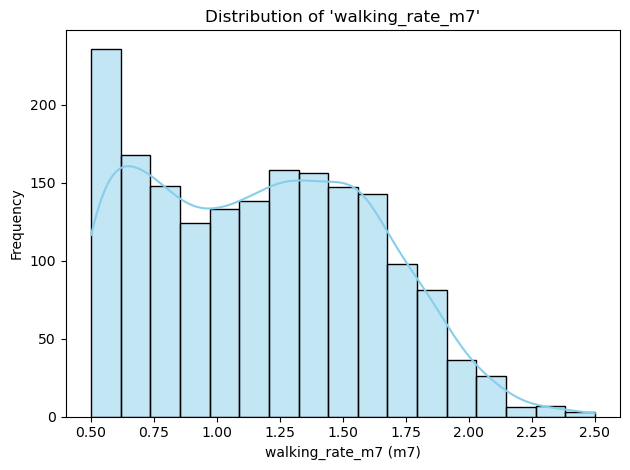

In [427]:
sns.histplot(df['walking_rate_m7'].dropna(),  kde=True, color='skyblue')
plt.title("Distribution of 'walking_rate_m7'")
plt.xlabel('walking_rate_m7 (m7)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

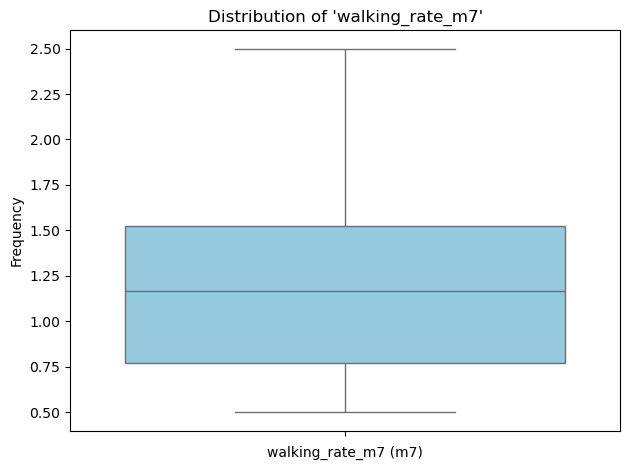

In [430]:
sns.boxplot(df['walking_rate_m7'].dropna(),   color='skyblue')
plt.title("Distribution of 'walking_rate_m7'")
plt.xlabel('walking_rate_m7 (m7)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [392]:
df[df.walking_rate_m7.notna()][['walking_rate_m7']].describe()

,walking_rate_m7
count,1808.000000
mean,1.170415
std,0.442706
min,0.500000
25%,0.772628
50%,1.167961
75%,1.522634
max,2.500000


In [387]:
keyword= 'wal'

a = [ col for col in df.columns if col.startswith(keyword)]
a 

['walking_rate_m7', 'walking_rate_m14', 'walking_rate_s7', 'walking_rate_s14']

In [388]:
import plotly.graph_objects as go
from statsmodels.distributions.empirical_distribution import ECDF

# Example DataFrame: df_clean
# Must have columns: ["walking_rate_m7", "age_bucket", "phq_category", "ethnicity_white", "gender", "major_depressive_disorder"]

groupings = {
    'age_bucket': ['16-18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84'],
    'phq_category': ['Minimal Depression', 'Mild Depression', 'Moderate Depression',
                     'Moderately Severe Depression', 'Severe Depression'],
    'ethnicity_white': [True, False],
    'gender': ['Woman', 'Man', 'Transgender', 'Gender Queer Or Nonconforming', ],
    #'major_depressive_disorder': ['Invalid Disorder', True, False]
}

for grouping_var, categories in groupings.items():
    # Create a new figure for each grouping
    fig = go.Figure()

    # For each category in this grouping, filter and plot the ECDF of walking_rate_m7
    for cat in categories:
        # Filter rows where the grouping_var matches cat
        sub_df = df[df[grouping_var] == cat]
        if sub_df.empty:
            continue
        
        # Drop any NaN values in walking_rate_m7
        values = sub_df['walking_rate_m7'].dropna()
        if values.empty:
            continue
        
        # Compute ECDF
        ecdf = ECDF(values)
        x_vals = ecdf.x
        y_vals = ecdf.y
        
        # Add a Scatter trace for this category
        fig.add_trace(
            go.Scatter(
                x=x_vals,
                y=y_vals,
                mode='lines',
                name=str(cat)  # This label shows in the legend
            )
        )
    
    # Update layout for this figure
    fig.update_layout(
        title=f"ECDF of walking_rate_m7 by {grouping_var}",
        xaxis_title="walking_rate_m7",
        yaxis_title="Proportion (ECDF)",
        legend_title=grouping_var,
        height=600,
        width=800
    )
    
    # Show (or save) the figure
    fig.show()
